# **GOLD PRICE ANALYSIS PROJECT (1994-2023)**

## **Data Understanding**

### 1. Deskripsi Dataset

* **Nama File**: `gold_1994-2023.xlsx`
* **Jumlah Baris**: 30
* **Jumlah Kolom**: 15
* **Periode Data**: 1994 – 2023
* **Topik Data**: Faktor makroekonomi dan komoditas yang berkaitan dengan **harga emas**.

---

### 2. Struktur Dataset

| Kolom        | Tipe Data | Keterangan                                     |
| ------------ | --------- | ---------------------------------------------- |
| `year`       | int64     | Tahun pengamatan (1994–2023)                   |
| `gold_price` | object    | Harga emas (perlu dibersihkan menjadi numerik) |
| `fed_rate`   | float64   | Suku bunga The Fed (%)                         |
| `inflation`  | float64   | Tingkat inflasi (%)                            |
| `ec_growth`  | float64   | Pertumbuhan ekonomi (%)                        |
| `exch_rate`  | float64   | Nilai tukar Rupiah per USD                     |
| `real_int`   | float64   | Suku bunga riil (%)                            |
| `gdp_def`    | float64   | Deflator PDB (%)                               |
| `cpo`        | float64   | Harga Crude Palm Oil (CPO)                     |
| `tin`        | float64   | Harga timah (Tin)                              |
| `lend_int`   | float64   | Suku bunga pinjaman (%)                        |
| `Aluminium`  | float64   | Harga aluminium                                |
| `Nickel`     | float64   | Harga nikel                                    |
| `Platinum`   | float64   | Harga platinum                                 |
| `Perak`      | float64   | Harga perak (silver)                           |

---

### 3. Kualitas Data

* **Missing Values**: Tidak ada missing values di semua kolom.
* **Inconsistent Data**:

  * `gold_price` masih dalam format **object**, kemungkinan mengandung tanda pemisah ribuan/koma → perlu dikonversi ke numerik.

---

### 4. Statistik Deskriptif

#### a. Variabel Utama (contoh ringkasan)

* **Tahun (`year`)**: 1994 – 2023
* **Harga Emas (`gold_price`)**: 30 nilai unik (setiap tahun berbeda, perlu dibersihkan)
* **Fed Rate (`fed_rate`)**: Rata-rata 2.47%, min 0.08%, max 6.24%
* **Inflasi (`inflation`)**: Rata-rata 8.48%, min 1.56%, max 58.45%
* **Pertumbuhan Ekonomi (`ec_growth`)**: Rata-rata 4.44%, min -13.12%, max 8.22%

#### b. Variabel Komoditas (contoh ringkasan)

* **CPO**: Rata-rata 54.9
* **Timah (`tin`)**: Rata-rata 14,534
* **Aluminium**: Rata-rata 1,884
* **Nikel**: Rata-rata 14,304
* **Platinum**: Rata-rata 934
* **Perak (Silver)**: Rata-rata 14.8

---

### 5. Insight Awal

* Dataset berfokus pada **hubungan harga emas** dengan faktor makroekonomi dan harga komoditas lain.
* Potensi analisis:

  * Korelasi harga emas dengan inflasi, suku bunga, nilai tukar.
  * Hubungan harga emas dengan komoditas lain (CPO, timah, aluminium, nikel, platinum, perak).

---

## **Data Preparation**

### Download Data

> ⚠️ **PERINGATAN**  
> PyCaret **tidak mendukung Python 3.12**.  
> Gunakan Python <= 3.11



In [1]:
# # 1. Clone repo
# !git clone https://github.com/maybeitsai/gold-price-prediction.git

# # 2. Pindahkan requirements.txt ke root Colab
# !rm requirements.txt
# !mv gold-price-prediction/requirements.txt .

# # 3. Pindahkan folder data ke root Colab
# !rm -rf data
# !mv gold-price-prediction/data .

# # 4. Hapus folder repo agar tidak menumpuk
# !rm -rf gold-price-prediction

# # 5. Cek hasil
# !ls -R

In [2]:
# !pip install uv
# !uv pip install -r requirements.txt

### Import Libraries

In [1]:
# General
import os
import random
import pickle
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# Data & Numerical
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Tests
from scipy import stats
from scipy.stats import normaltest, shapiro, jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Time Series Analysis
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen
# from arch import arch_model  # Uncomment jika mau pakai ARCH/GARCH

# Machine Learning
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb

# Deep Learning (TensorFlow/Keras)
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import (
        Dense, Dropout, LSTM, GRU,
        Conv1D, MaxPooling1D, Flatten
    )
    from tensorflow.keras.callbacks import EarlyStopping
    KERAS_AVAILABLE = True
except ImportError:
    KERAS_AVAILABLE = False
    print("TensorFlow/Keras not available. Deep Learning models will be skipped.")

# PyCaret
from pycaret.regression import (
    setup, compare_models, create_model,
    tune_model, finalize_model, predict_model,
    pull, save_model, load_model
)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### Seeding

In [4]:
SEED = 42

# Python & OS
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# XGBoost
xgb_rng = np.random.RandomState(SEED)

# TensorFlow / Keras
if KERAS_AVAILABLE:
    tf.random.set_seed(SEED)
    tf.keras.backend.clear_session()

print(f"Global seeding berhasil dengan SEED={SEED}")

Global seeding berhasil dengan SEED=42


## **Eksploratory Data Analysis (EDA)**

In [5]:
# Load data
df = pd.read_excel('data/gold_1994-2023.xlsx')

In [6]:
print("\n0.1.1 DESKRIPSI DATASET")
print("-"*80)
print(f"Nama File: gold_1994-2023.xlsx")
print(f"Jumlah Baris: {df.shape[0]}")
print(f"Jumlah Kolom: {df.shape[1]}")
print(f"Periode Data: {df['year'].min()} - {df['year'].max()}")


0.1.1 DESKRIPSI DATASET
--------------------------------------------------------------------------------
Nama File: gold_1994-2023.xlsx
Jumlah Baris: 30
Jumlah Kolom: 16
Periode Data: 1994 - 2023


In [7]:
print("\n0.1.2 STRUKTUR DATASET")
print("-"*80)
print(df.info())
print("\nFirst 5 rows:")
print(df.head())


0.1.2 STRUKTUR DATASET
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         30 non-null     int64  
 1   gold_price   30 non-null     float64
 2   fed_rate     30 non-null     float64
 3   inflation    30 non-null     float64
 4   ec_growth    30 non-null     float64
 5   exch_rate    30 non-null     float64
 6   real_int     30 non-null     float64
 7   gdp_def      30 non-null     float64
 8   cpo          30 non-null     float64
 9   tin          30 non-null     float64
 10  lend_int     30 non-null     float64
 11  Aluminium    30 non-null     float64
 12  Nickel       30 non-null     float64
 13  Platinum     30 non-null     float64
 14  Perak        30 non-null     float64
 15  Unnamed: 15  1 non-null      object 
dtypes: float64(14), int64(1), objec

In [8]:
# Remove unnamed columns if any
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Clean gold_price column (remove comma/thousands separator)
if df['gold_price'].dtype == 'object':
    df['gold_price'] = df['gold_price'].str.replace(',', '').str.replace('.', '').astype(float)

In [9]:
print("\n0.1.3 KUALITAS DATA")
print("-"*80)
print("Missing Values:")
print(df.isnull().sum())
print(f"\nTotal Missing Values: {df.isnull().sum().sum()}")



0.1.3 KUALITAS DATA
--------------------------------------------------------------------------------
Missing Values:
year          0
gold_price    0
fed_rate      0
inflation     0
ec_growth     0
exch_rate     0
real_int      0
gdp_def       0
cpo           0
tin           0
lend_int      0
Aluminium     0
Nickel        0
Platinum      0
Perak         0
dtype: int64

Total Missing Values: 0


In [10]:
print("\n0.1.4 STATISTIK DESKRIPTIF")
print("-"*80)
print(df.describe())


0.1.4 STATISTIK DESKRIPTIF
--------------------------------------------------------------------------------
              year   gold_price  fed_rate  inflation  ec_growth     exch_rate  \
count    30.000000    30.000000  30.00000  30.000000  30.000000     30.000000   
mean   2008.500000   935.523338   2.46600   8.481230   4.438370   9938.259521   
std       8.803408   573.425888   2.21228  10.233847   3.821554   3754.664354   
min    1994.000000   270.989167   0.08000   1.560130 -13.126725   2160.753675   
25%    2001.250000   384.048542   0.22750   3.908965   4.720001   8812.537500   
50%    2008.500000   922.336583   1.76000   6.294631   5.040587   9701.852083   
75%    2015.750000  1361.680417   4.97000   9.198244   5.933421  13362.707110   
max    2023.000000  1942.665833   6.24000  58.451044   8.220007  15236.884662   

        real_int    gdp_def         cpo           tin   lend_int    Aluminium  \
count  30.000000  30.000000   30.000000     30.000000  30.000000    30.000000   

In [11]:
# Correlation with gold_price
print("\nKorelasi dengan Harga Emas:")
correlations = df.corr()['gold_price'].sort_values(ascending=False)
print(correlations)

print("\n0.1.5 INSIGHT AWAL")
print("-"*80)
print("✓ Dataset fokus pada hubungan harga emas dengan faktor makroekonomi")
print("✓ Periode analisis: 30 tahun (1994-2023)")
print("✓ Variabel ekonomi: Fed rate, inflasi, pertumbuhan ekonomi, nilai tukar")
print("✓ Variabel komoditas: CPO, timah, aluminium, nikel, platinum, perak")


Korelasi dengan Harga Emas:
gold_price    1.000000
tin           0.942993
year          0.922562
Perak         0.885612
cpo           0.753968
exch_rate     0.710543
Platinum      0.641273
Aluminium     0.561791
Nickel        0.507015
real_int      0.113259
ec_growth     0.091401
gdp_def      -0.423295
inflation    -0.442662
fed_rate     -0.619093
lend_int     -0.795449
Name: gold_price, dtype: float64

0.1.5 INSIGHT AWAL
--------------------------------------------------------------------------------
✓ Dataset fokus pada hubungan harga emas dengan faktor makroekonomi
✓ Periode analisis: 30 tahun (1994-2023)
✓ Variabel ekonomi: Fed rate, inflasi, pertumbuhan ekonomi, nilai tukar
✓ Variabel komoditas: CPO, timah, aluminium, nikel, platinum, perak


## **Trend Visualization**

### Gold Price Trend

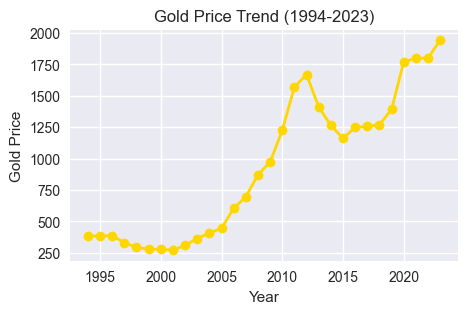

In [12]:
plt.figure(figsize=(5,3))
plt.plot(df['year'], df['gold_price'], marker='o', linewidth=2, color='gold')
plt.title('Gold Price Trend (1994-2023)')
plt.xlabel('Year')
plt.ylabel('Gold Price')
plt.grid(True)
plt.show()

### Fed Rate Trend

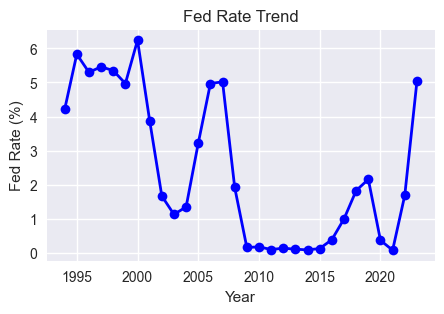

In [13]:

plt.figure(figsize=(5,3))
plt.plot(df['year'], df['fed_rate'], marker='o', linewidth=2, color='blue')
plt.title('Fed Rate Trend')
plt.xlabel('Year')
plt.ylabel('Fed Rate (%)')
plt.grid(True)
plt.show()

### Inflation Trend

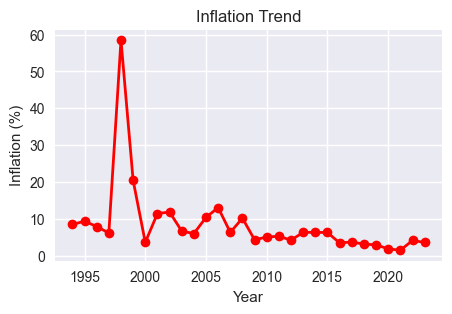

In [14]:

plt.figure(figsize=(5,3))
plt.plot(df['year'], df['inflation'], marker='o', linewidth=2, color='red')
plt.title('Inflation Trend')
plt.xlabel('Year')
plt.ylabel('Inflation (%)')
plt.grid(True)
plt.show()

### Exchange Rate Trend

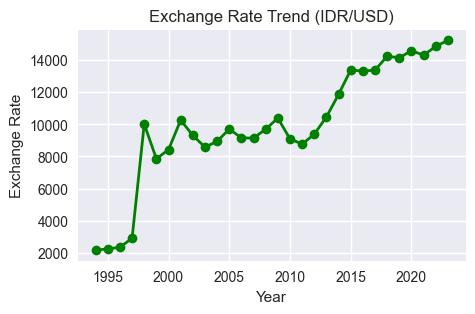

In [15]:
plt.figure(figsize=(5,3))
plt.plot(df['year'], df['exch_rate'], marker='o', linewidth=2, color='green')
plt.title('Exchange Rate Trend (IDR/USD)')
plt.xlabel('Year')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

### Correlation Heatmap

In [16]:
df.columns

Index(['year', 'gold_price', 'fed_rate', 'inflation', 'ec_growth', 'exch_rate',
       'real_int', 'gdp_def', 'cpo', 'tin', 'lend_int', 'Aluminium', 'Nickel',
       'Platinum', 'Perak'],
      dtype='object')

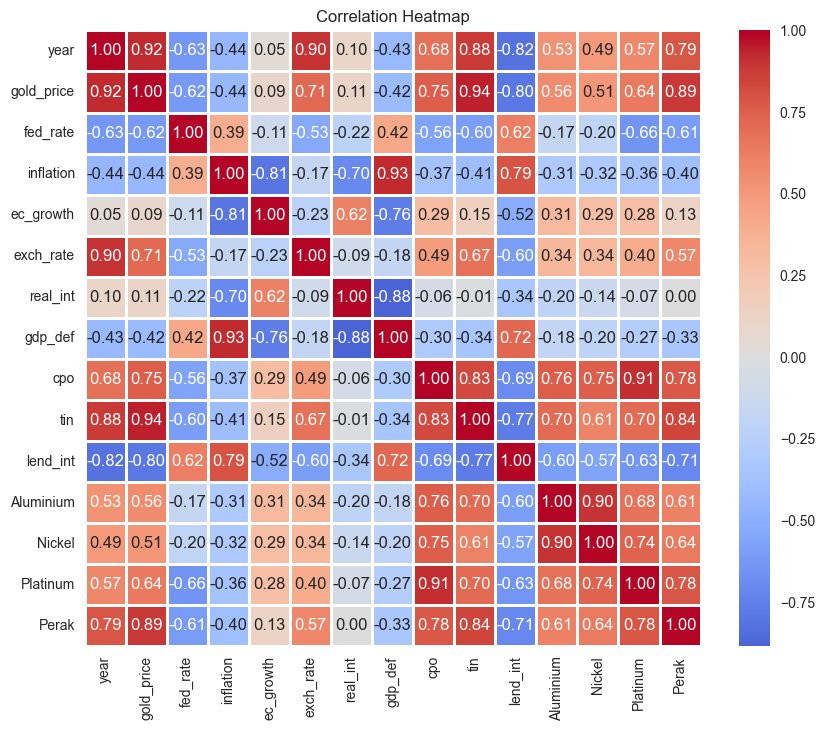

In [17]:
corr_matrix = df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1)
plt.title('Correlation Heatmap')
plt.show()

### Distribution of Gold Price

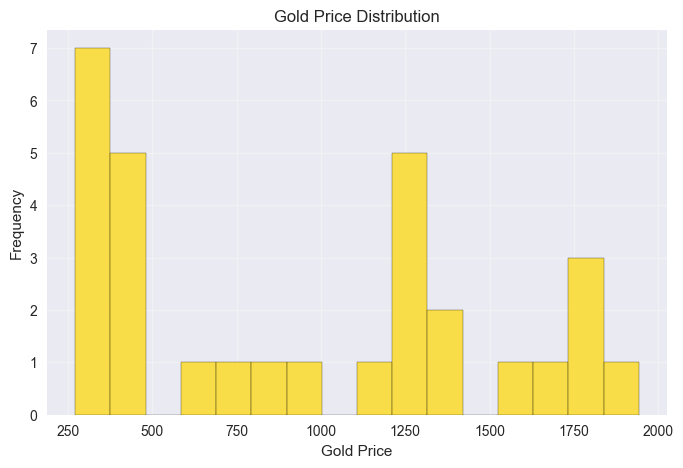

In [18]:
plt.figure(figsize=(8,5))
plt.hist(df['gold_price'], bins=16, color='gold', edgecolor='black', alpha=0.7)
plt.title('Gold Price Distribution')
plt.xlabel('Gold Price')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()


## **Data Testing**

### Classic Test (Stationarity)

In [19]:
X = df.drop(['year', 'gold_price'], axis=1)
y = df['gold_price']

# --- 1. Log Transformation (optional)
y_log = np.log(y)

# --- 2. First Differencing
y_diff = y.diff().dropna()

# --- 3. Log + Differencing
y_logdiff = y_log.diff().dropna()

In [20]:
def stationarity_tests(series, name="Series"):
    print(f"\n>>> Uji Stasioneritas untuk {name}")
    print("-"*80)

    # KPSS Test
    kpss_result = kpss(series, regression='c', nlags="auto")
    print(f"\nKPSS Test:")
    print(f"  KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"  p-value: {kpss_result[1]:.4f}")
    print(f"  Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"    {key}: {value:.4f}")
    if kpss_result[1] > 0.05:
        print("  → Data STASIONER (p > 0.05)")
    else:
        print("  → Data TIDAK STASIONER (p <= 0.05)")

#### Pengujian

In [21]:
stationarity_tests(y, "Original Data (Gold Price)")


>>> Uji Stasioneritas untuk Original Data (Gold Price)
--------------------------------------------------------------------------------

KPSS Test:
  KPSS Statistic: 0.7722
  p-value: 0.0100
  Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
  → Data TIDAK STASIONER (p <= 0.05)


In [22]:
stationarity_tests(y_log.dropna(), "Log Transform")


>>> Uji Stasioneritas untuk Log Transform
--------------------------------------------------------------------------------

KPSS Test:
  KPSS Statistic: 0.7545
  p-value: 0.0100
  Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
  → Data TIDAK STASIONER (p <= 0.05)


In [23]:
stationarity_tests(y_diff, "First Difference")


>>> Uji Stasioneritas untuk First Difference
--------------------------------------------------------------------------------

KPSS Test:
  KPSS Statistic: 0.1394
  p-value: 0.1000
  Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
  → Data STASIONER (p > 0.05)


In [24]:
stationarity_tests(y_logdiff, "Log + First Difference")


>>> Uji Stasioneritas untuk Log + First Difference
--------------------------------------------------------------------------------

KPSS Test:
  KPSS Statistic: 0.1292
  p-value: 0.1000
  Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
  → Data STASIONER (p > 0.05)


### Heterokedastatis Test

In [25]:
print("\n0.2.2 HETEROSKEDASTICITY TEST")
print("-"*80)

# Simple linear regression for residuals
from sklearn.linear_model import LinearRegression
from statsmodels.tools import add_constant

lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)
residuals = y - y_pred

# Add constant to X for Breusch-Pagan test (required by statsmodels)
X_with_const = add_constant(X)

# Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X_with_const)
print("Breusch-Pagan Test:")
print(f"  LM Statistic: {bp_test[0]:.4f}")
print(f"  p-value: {bp_test[1]:.4f}")
print(f"  F-statistic: {bp_test[2]:.4f}")
print(f"  F p-value: {bp_test[3]:.4f}")
if bp_test[1] < 0.05:
    print("  → HETEROSKEDASTISITAS TERDETEKSI (p < 0.05)")
else:
    print("  → HOMOSKEDASTISITAS (p >= 0.05)")


0.2.2 HETEROSKEDASTICITY TEST
--------------------------------------------------------------------------------
Breusch-Pagan Test:
  LM Statistic: 12.2686
  p-value: 0.5057
  F-statistic: 0.8516
  F p-value: 0.6101
  → HOMOSKEDASTISITAS (p >= 0.05)


### Autocorrelation Test

In [26]:
print("\n0.2.3 AUTOCORRELATION TEST")
print("-"*80)

# Durbin-Watson test
dw_stat = durbin_watson(residuals)
print("Durbin-Watson Test:")
print(f"  DW Statistic: {dw_stat:.4f}")
if dw_stat < 1.5:
    print("  → AUTOKORELASI POSITIF")
elif dw_stat > 2.5:
    print("  → AUTOKORELASI NEGATIF")
else:
    print("  → TIDAK ADA AUTOKORELASI")

# Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
print(f"\nLjung-Box Test (lag 1):")
print(f"  Statistic: {lb_test['lb_stat'].iloc[0]:.4f}")
print(f"  p-value: {lb_test['lb_pvalue'].iloc[0]:.4f}")
if lb_test['lb_pvalue'].iloc[0] < 0.05:
    print("  → AUTOKORELASI TERDETEKSI")
else:
    print("  → TIDAK ADA AUTOKORELASI")


0.2.3 AUTOCORRELATION TEST
--------------------------------------------------------------------------------
Durbin-Watson Test:
  DW Statistic: 2.2447
  → TIDAK ADA AUTOKORELASI

Ljung-Box Test (lag 1):
  Statistic: 0.5628
  p-value: 0.4531
  → TIDAK ADA AUTOKORELASI


### Multi Correlation Test

In [27]:
X.columns

Index(['fed_rate', 'inflation', 'ec_growth', 'exch_rate', 'real_int',
       'gdp_def', 'cpo', 'tin', 'lend_int', 'Aluminium', 'Nickel', 'Platinum',
       'Perak'],
      dtype='object')

In [28]:
def calc_vif(df):
    """Fungsi untuk menghitung VIF dari DataFrame"""
    vif_data = pd.DataFrame()
    vif_data["Variable"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

#### Data Asli

In [29]:
print("\n[1] VIF pada Data Asli (raw features)")
vif_original = calc_vif(X)
print(vif_original)


[1] VIF pada Data Asli (raw features)
     Variable         VIF
5     gdp_def  408.439213
8    lend_int  376.572611
9   Aluminium  190.341468
4    real_int  141.726385
11   Platinum  121.662181
6         cpo   72.126704
7         tin   52.394930
10     Nickel   37.479860
1   inflation   34.101870
12      Perak   24.300016
3   exch_rate   19.170536
2   ec_growth   18.629027
0    fed_rate   14.229006


#### PCA

In [30]:
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [31]:
pca = PCA(random_state=42)
X_pca = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)

n_components = np.argmax(cum_explained_var >= 0.95) + 1
pca_opt = PCA(n_components=n_components, random_state=42)
X_reduced = pca_opt.fit_transform(X_scaled)

X_pca_df = pd.DataFrame(X_reduced, columns=[f"PC{i+1}" for i in range(X_reduced.shape[1])], index=X.index)

print(f"\n[2] PCA (setelah Robust Scaling): Jumlah komponen optimal (>=95% variansi terjaga): {n_components}")
print("Dimensi asli:", X.shape[1])
print("Dimensi baru setelah PCA:", X_pca_df.shape[1])

print("\nVIF pada Data PCA:")
vif_pca = calc_vif(X_pca_df)
print(vif_pca)


[2] PCA (setelah Robust Scaling): Jumlah komponen optimal (>=95% variansi terjaga): 4
Dimensi asli: 13
Dimensi baru setelah PCA: 4

VIF pada Data PCA:
  Variable  VIF
0      PC1  1.0
1      PC2  1.0
2      PC3  1.0
3      PC4  1.0


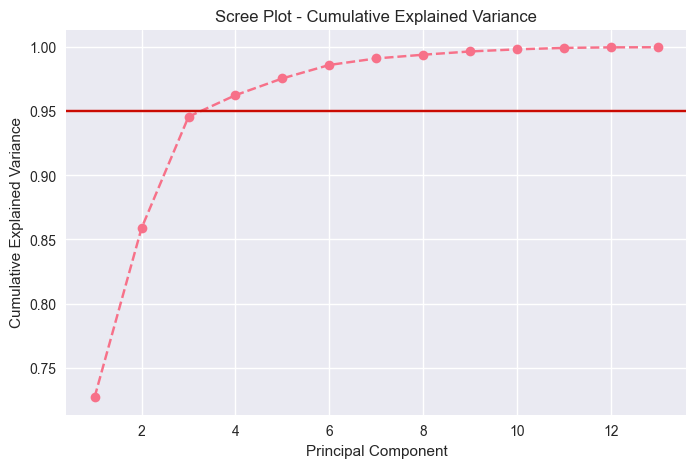

In [32]:
# Scree Plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), cum_explained_var, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.title("Scree Plot - Cumulative Explained Variance")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [33]:
X_pca_df

,PC1,PC2,PC3,PC4
0,-1.948341,3.061874,0.043614,-0.049601
1,-2.210354,3.204331,-0.700505,-0.010001
2,-2.134355,3.163195,-0.106364,-0.024228
3,-0.050214,2.256554,0.734382,0.480912
4,19.484552,0.002873,-1.366030,-0.042442
5,3.782769,1.886433,1.781954,-1.159674
6,0.125116,1.353127,-0.325282,1.941381
7,1.242064,1.285791,0.642109,0.532181
8,0.134062,1.641844,1.455551,-0.654734
9,-0.554551,1.133940,1.338883,-0.160888


#### Feature Importance (Random Forest)

In [34]:
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_scaled, y)

selector = SelectFromModel(rf, threshold="median", prefit=True)
X_selected = selector.transform(X_scaled)
selected_cols = X_scaled.columns[selector.get_support()]
X_rfr = pd.DataFrame(X_selected, columns=selected_cols, index=X.index)

print("\n[3] Feature Selection (Random Forest, threshold >= median)")
print("Fitur terpilih:", list(selected_cols))
print("Jumlah fitur awal:", X.shape[1])
print("Jumlah fitur setelah seleksi:", X_rfr.shape[1])

print("\nVIF pada Data Seleksi Random Forest:")
vif_rf = calc_vif(X_rfr)
print(vif_rf)


[3] Feature Selection (Random Forest, threshold >= median)
Fitur terpilih: ['fed_rate', 'inflation', 'exch_rate', 'cpo', 'tin', 'lend_int', 'Perak']
Jumlah fitur awal: 13
Jumlah fitur setelah seleksi: 7

VIF pada Data Seleksi Random Forest:
    Variable        VIF
5   lend_int  10.712220
4        tin   6.209759
1  inflation   5.163216
6      Perak   3.954321
3        cpo   3.414029
2  exch_rate   2.491826
0   fed_rate   1.863967


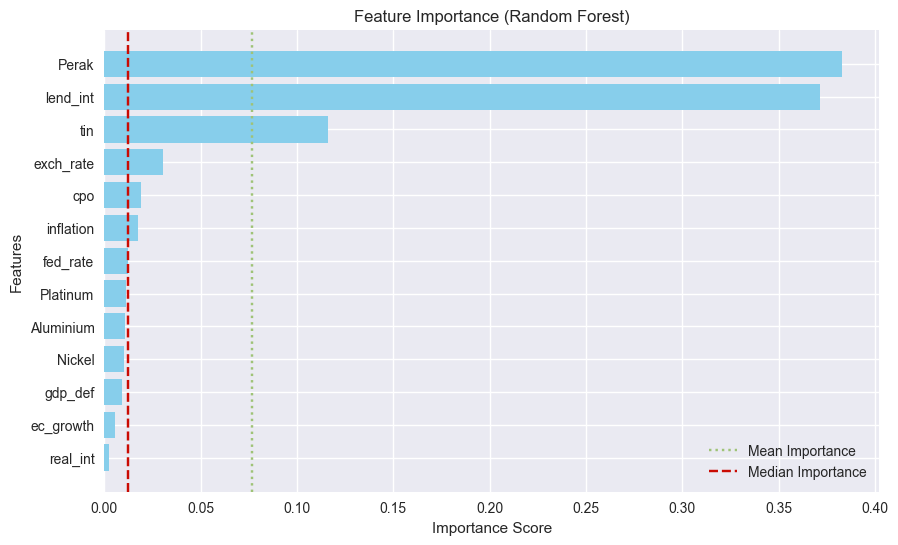

In [35]:
# Visualisasi Feature Importance
importances = rf.feature_importances_
feat_importance_df = pd.DataFrame({
    'Variable': X.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_importance_df['Variable'], feat_importance_df['Importance'], color='skyblue')
plt.axvline(x=importances.mean(), color='g', linestyle=':', label="Mean Importance")
plt.axvline(x=np.median(importances), color='r', linestyle='--', label="Median Importance")
plt.gca().invert_yaxis()
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.legend()
plt.show()

### Normality Test


0.2.5 NORMALITY TEST
--------------------------------------------------------------------------------
Jarque-Bera Test:
  Statistic: 4.1588
  p-value: 0.1250
  → Data BERDISTRIBUSI NORMAL (p >= 0.05)

Shapiro-Wilk Test:
  Statistic: 0.9595
  p-value: 0.3001
  → Data BERDISTRIBUSI NORMAL (p >= 0.05)


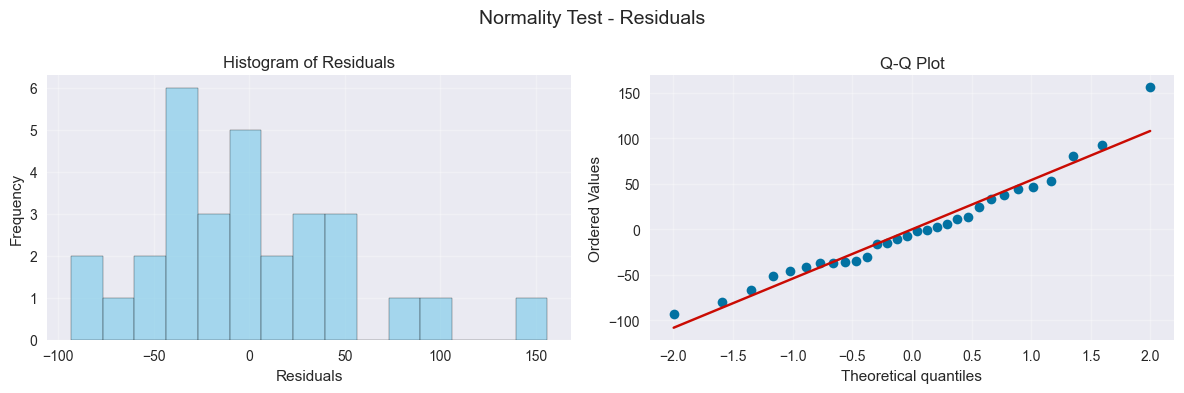

In [36]:
print("\n0.2.5 NORMALITY TEST")
print("-"*80)

# Jarque-Bera test
jb_stat, jb_pvalue = jarque_bera(residuals)
print("Jarque-Bera Test:")
print(f"  Statistic: {jb_stat:.4f}")
print(f"  p-value: {jb_pvalue:.4f}")
if jb_pvalue < 0.05:
    print("  → Data TIDAK BERDISTRIBUSI NORMAL (p < 0.05)")
else:
    print("  → Data BERDISTRIBUSI NORMAL (p >= 0.05)")

# Shapiro-Wilk test
shapiro_stat, shapiro_pvalue = shapiro(residuals)
print(f"\nShapiro-Wilk Test:")
print(f"  Statistic: {shapiro_stat:.4f}")
print(f"  p-value: {shapiro_pvalue:.4f}")
if shapiro_pvalue < 0.05:
    print("  → Data TIDAK BERDISTRIBUSI NORMAL (p < 0.05)")
else:
    print("  → Data BERDISTRIBUSI NORMAL (p >= 0.05)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Normality Test - Residuals', fontsize=14)

# Histogram
axes[0].hist(residuals, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Histogram of Residuals')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Econometric Test

In [37]:
variabels = df.columns.tolist()
variabels.remove('year')

In [38]:
variabels

['gold_price',
 'fed_rate',
 'inflation',
 'ec_growth',
 'exch_rate',
 'real_int',
 'gdp_def',
 'cpo',
 'tin',
 'lend_int',
 'Aluminium',
 'Nickel',
 'Platinum',
 'Perak']

In [39]:
print("\n0.2.6 ECONOMETRIC TEST")
print("-"*80)

# Granger Causality Test (example: fed_rate -> gold_price)
print("Granger Causality Test (Fed Rate → Gold Price):")
data_granger = df[['gold_price', 'fed_rate']].dropna()
try:
    gc_result = grangercausalitytests(data_granger, maxlag=3, verbose=False)
    for lag in range(1, 4):
        p_value = gc_result[lag][0]['ssr_ftest'][1]
        print(f"  Lag {lag}: p-value = {p_value:.4f}")
        if p_value < 0.05:
            print(f"    → Fed Rate Granger-cause Gold Price (p < 0.05)")
        else:
            print(f"    → No Granger causality (p >= 0.05)")
except:
    print("  Unable to perform Granger test (insufficient data or singularity)")

# Cointegration Test (Johansen)
print("\nJohansen Cointegration Test:")
selected_vars = df[['gold_price', 'fed_rate', 'inflation', 'exch_rate']].dropna()
try:
    johansen_result = coint_johansen(selected_vars, det_order=0, k_ar_diff=1)
    print(f"  Trace Statistic:")
    for i in range(len(johansen_result.lr1)):
        print(f"    r <= {i}: {johansen_result.lr1[i]:.4f} (Critical 5%: {johansen_result.cvt[i, 1]:.4f})")
except:
    print("  Unable to perform Johansen test")


0.2.6 ECONOMETRIC TEST
--------------------------------------------------------------------------------
Granger Causality Test (Fed Rate → Gold Price):
  Lag 1: p-value = 0.8623
    → No Granger causality (p >= 0.05)
  Lag 2: p-value = 0.6985
    → No Granger causality (p >= 0.05)
  Lag 3: p-value = 0.6302
    → No Granger causality (p >= 0.05)

Johansen Cointegration Test:
  Trace Statistic:
    r <= 0: 60.3616 (Critical 5%: 47.8545)
    r <= 1: 20.6135 (Critical 5%: 29.7961)
    r <= 2: 8.3645 (Critical 5%: 15.4943)
    r <= 3: 0.2093 (Critical 5%: 3.8415)


## **Kesimpulan Hasil Pengujian Data**

1. **Uji Stasioneritas (ADF & KPSS)**

   * Hasil **ADF Test** menunjukkan p-value = 0.9820 (≥ 0.05) → **tidak stasioner**.
   * Hasil **KPSS Test** menunjukkan p-value = 0.0100 (≤ 0.05) → **tidak stasioner**.
    
    **Kesimpulan:** Data belum stasioner, perlu dilakukan transformasi/differencing sebelum masuk ke model deret waktu.

2. **Uji Heteroskedastisitas (Breusch-Pagan)**

   * p-value LM = 0.5057 dan F = 0.6101 (≥ 0.05) → **tidak ada heteroskedastisitas**.
    
    **Kesimpulan:** Varian residual konstan (homoskedastis).

3. **Uji Autokorelasi (Durbin-Watson & Ljung-Box)**

   * **Durbin-Watson** = 2.2447 (mendekati 2) → tidak ada autokorelasi.
   * **Ljung-Box** p-value = 0.4531 (≥ 0.05) → tidak ada autokorelasi.
    
     **Kesimpulan:** Residual bebas dari autokorelasi.

4. **Uji Multikolinearitas (VIF)**

   * Banyak variabel memiliki **VIF jauh > 10**, misalnya `gdp_def` (408), `lend_int` (376), `Aluminium` (190), dll.
    
    **Kesimpulan:** Terjadi **multikolinearitas sangat tinggi**, sehingga perlu reduksi variabel (misalnya PCA, regularisasi, atau eliminasi variabel).

5. **Uji Normalitas (Jarque-Bera & Shapiro-Wilk)**

   * p-value JB = 0.1250 dan SW = 0.3001 (≥ 0.05).
    
    **Kesimpulan:** Data residual **berdistribusi normal**.

6. **Uji Ekonometrik**

   * **Granger Causality (Fed Rate → Gold Price):** semua lag (1–3) p-value ≥ 0.05 → **tidak ada hubungan sebab akibat jangka pendek**.
   * **Johansen Cointegration Test:**

     * r ≤ 0: 60.3616 > 47.8545 → terdapat minimal **1 vektor kointegrasi**.
     * r ≤ 1, r ≤ 2, r ≤ 3 tidak signifikan → hanya ada **1 hubungan kointegrasi jangka panjang**.
     
      **Kesimpulan:** Tidak ada hubungan kausal jangka pendek, tetapi ada **kointegrasi jangka panjang** antar variabel.

---

### Ringkasan

* Data **tidak stasioner** → perlu differencing/transformasi.
* Data **homoskedastis** dan **tidak ada autokorelasi**, sehingga residual sudah memenuhi asumsi klasik.
* **Multikolinearitas sangat tinggi** → model regresi linear biasa kurang tepat; perlu penanganan khusus.
* Residual **normal** → asumsi distribusi terpenuhi.
* Secara ekonometrik, **tidak ada hubungan kausal jangka pendek** (Granger), tetapi terdapat **hubungan jangka panjang (kointegrasi)** antar variabel.


# **Proses Pemodelan berdasarkan Hasil Pengujian dan Analisis**

## **Data Preparation**

### Import Libraries

In [40]:
DATA_PATH = "data/gold_1994-2023.xlsx"
df = pd.read_excel(DATA_PATH)

In [41]:
# Bersihkan
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
if df['gold_price'].dtype == 'object':
    df['gold_price'] = df['gold_price'].astype(str).str.replace(',', '').str.replace('.', '').astype(float)

In [42]:
TARGET = 'gold_price'
FEATURES = [c for c in df.columns if c not in ['year', TARGET]]

X = df[FEATURES].fillna(df[FEATURES].median())
y = df[TARGET]

## **Data Preprocessing**

#### Data Scaling

In [43]:
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

####  Principal Component Analysis (PCA)

In [44]:
# 1. Jalankan PCA tanpa menentukan jumlah komponen dulu
pca = PCA(random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 2. Variance explained ratio
explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)

# 3. Tampilkan hasil
print("Explained Variance Ratio per Komponen:")
for i, ev in enumerate(explained_var, start=1):
    print(f"  PC{i}: {ev:.4f} ({cum_explained_var[i-1]:.4f} kumulatif)")

Explained Variance Ratio per Komponen:
  PC1: 0.7269 (0.7269 kumulatif)
  PC2: 0.1320 (0.8588 kumulatif)
  PC3: 0.0869 (0.9458 kumulatif)
  PC4: 0.0168 (0.9626 kumulatif)
  PC5: 0.0131 (0.9757 kumulatif)
  PC6: 0.0105 (0.9862 kumulatif)
  PC7: 0.0051 (0.9913 kumulatif)
  PC8: 0.0029 (0.9942 kumulatif)
  PC9: 0.0026 (0.9967 kumulatif)
  PC10: 0.0016 (0.9984 kumulatif)
  PC11: 0.0011 (0.9995 kumulatif)
  PC12: 0.0004 (0.9999 kumulatif)
  PC13: 0.0001 (1.0000 kumulatif)



Jumlah komponen optimal (>=95% variansi terjaga): 4

Dimensi asli: 13
Dimensi baru setelah PCA: 4


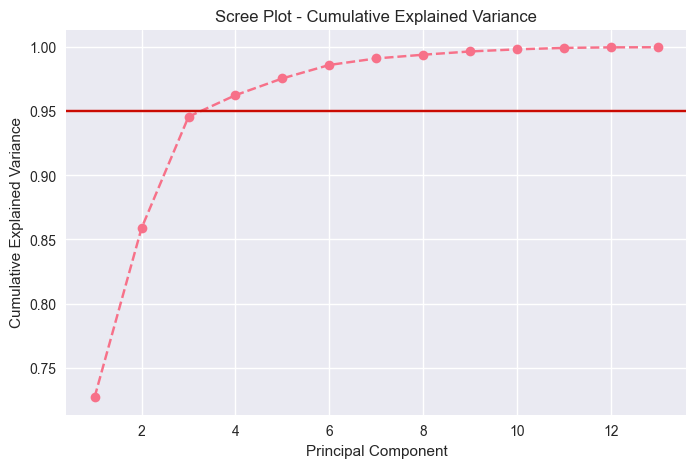

In [45]:
# 4. Tentukan jumlah komponen optimal
n_components = np.argmax(cum_explained_var >= 0.95) + 1
print(f"\nJumlah komponen optimal (>=95% variansi terjaga): {n_components}")

# 5. Transformasi ulang data dengan PCA optimal
pca_opt = PCA(n_components=n_components)
X_reduced = pca_opt.fit_transform(X_scaled)

print("\nDimensi asli:", X.shape[1])
print("Dimensi baru setelah PCA:", X_reduced.shape[1])

# 6. Visualisasi Scree Plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), cum_explained_var, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.title("Scree Plot - Cumulative Explained Variance")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [46]:
X_pca = pd.DataFrame(X_reduced, columns=[f"PC{i+1}" for i in range(X_reduced.shape[1])], index=X.index)

#### Feature Importance

In [47]:
# 1. Definisikan model
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_scaled, y)

# 2. Seleksi fitur otomatis (importance >= median)
selector = SelectFromModel(rf, threshold="median", prefit=True)

# 3. Ambil dataset baru dengan fitur terpilih
X_selected = selector.transform(X_scaled)
selected_cols = X_scaled.columns[selector.get_support()]
X_rfr = pd.DataFrame(X_selected, columns=selected_cols, index=X_scaled.index)

In [48]:
# 4. Tampilkan hasil
print("Fitur terpilih (importance >= median):")
print(list(selected_cols))
print("\nJumlah fitur awal:", X.shape[1])
print("Jumlah fitur setelah seleksi:", X_rfr.shape[1])

Fitur terpilih (importance >= median):
['fed_rate', 'inflation', 'exch_rate', 'cpo', 'tin', 'lend_int', 'Perak']

Jumlah fitur awal: 13
Jumlah fitur setelah seleksi: 7


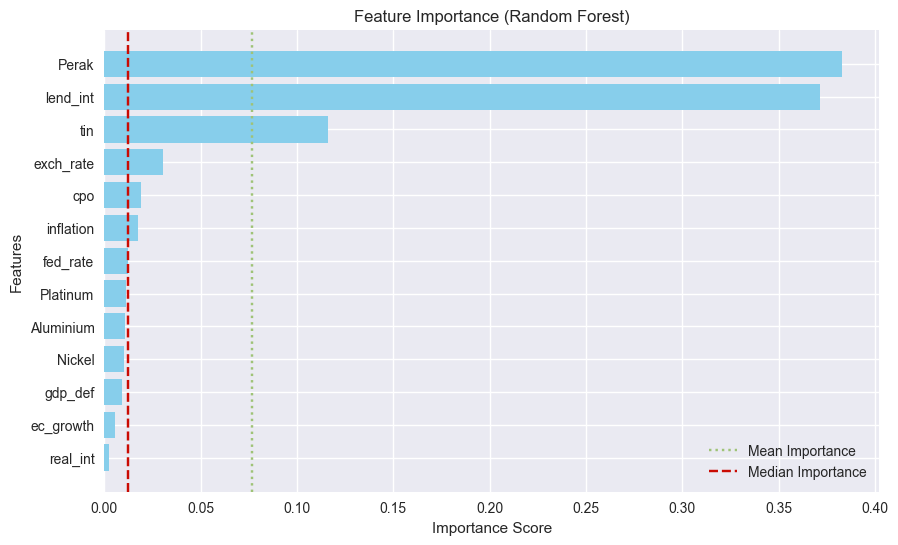

In [49]:
# 5. Visualisasi Feature Importance
importances = rf.feature_importances_
feat_importance_df = pd.DataFrame({
    'Variable': X_scaled.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_importance_df['Variable'], feat_importance_df['Importance'], color='skyblue')
plt.axvline(x=importances.mean(), color='g', linestyle=':', label="Mean Importance")
plt.axvline(x=np.median(importances), color='r', linestyle='--', label="Median Importance")
plt.gca().invert_yaxis()
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.legend()
plt.show()

> There are 3 schemes namely PCA, Feature Importance (RFR), and no Feature Selection or Reduction

## **Modelling**

### Preparation

In [50]:
results = []

# Helper: evaluasi metric
def calculate_metrics(y_true, y_pred, model_name, feature_selection):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "model": model_name,
        "feature_selection": feature_selection,
        "r2_score": r2_score(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "mape": np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        "mse": mse,
        "rmse": np.sqrt(mse)
    }

# Dataset untuk 3 skema
datasets = {
    "all_variables": X_scaled,
    "pca": X_pca,
    "feature_importance": X_rfr
}

TARGET = y.name

print("Dataset shapes:")
for name, data in datasets.items():
    print(f"  {name}: {data.shape}")

Dataset shapes:
  all_variables: (30, 13)
  pca: (30, 4)
  feature_importance: (30, 7)


### Model Tree-Based

In [51]:
# Daftar model TREE-BASED di PyCaret
tree_based_models = [
    'dt',        # Decision Tree Regressor
    'rf',        # Random Forest Regressor
    'et',        # Extra Trees Regressor
    'ada',       # AdaBoost Regressor
    'gbr',       # Gradient Boosting Regressor
    'xgboost',   # Extreme Gradient Boosting
    'lightgbm',  # Light Gradient Boosting Machine
    'catboost'   # CatBoost Regressor
]

#### All Variables

In [52]:
ml_data_all = pd.concat([datasets["all_variables"].reset_index(drop=True),
                         y.reset_index(drop=True)], axis=1)

setup(data=ml_data_all, target=TARGET, train_size=0.8,
      session_id=42, verbose=False, fold=3)

all_models_tree = compare_models(
    include=tree_based_models,sort="R2", n_select=len(tree_based_models),
    verbose=False, cross_validation=True, fold=3
)

comparison_results_all_tree = pull()
display(comparison_results_all_tree.style.background_gradient(cmap="Blues"))

for idx, row in comparison_results_all_tree.iterrows():
    model_name = row['Model']
    r2 = row['R2']
    mae = row['MAE']
    mse = row['MSE']
    rmse = row['RMSE']
    mape = row['MAPE']
    
    results.append({
        'model': model_name,
        'feature_selection': 'all_variables',
        'r2_score': r2,
        'mae': mae,
        'mape': mape,
        'mse': mse,
        'rmse': rmse,
        'is_tuned': False,
        'is_linear': False
    })

print(f"✓ Completed {len(comparison_results_all_tree)} tree models for all_variables")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,117.464500,25014.202500,153.516400,0.922300,0.179000,0.149000,1.746700
gbr,Gradient Boosting Regressor,139.905500,41264.193900,200.404800,0.868200,0.186600,0.156400,1.783300
catboost,CatBoost Regressor,186.282100,59847.137000,242.500500,0.806800,0.266700,0.244700,0.706700
rf,Random Forest Regressor,185.728200,67246.864300,247.711100,0.794400,0.253200,0.228500,1.820000
et,Extra Trees Regressor,192.226800,70376.258300,252.098700,0.780700,0.239700,0.212600,1.783300
dt,Decision Tree Regressor,270.257700,145798.966700,374.376600,0.491800,0.391500,0.284400,2.076700
lightgbm,Light Gradient Boosting Machine,519.115100,322607.062200,566.051700,-0.045900,0.735000,0.916500,0.026700
xgboost,Extreme Gradient Boosting,443.858300,373064.302100,604.186500,-0.271400,0.707900,0.528600,1.670000


✓ Completed 8 tree models for all_variables


#### PCA

In [53]:
ml_data_pca = pd.concat([datasets["pca"].reset_index(drop=True),
                         y.reset_index(drop=True)], axis=1)

setup(data=ml_data_pca, target=TARGET, train_size=0.8,
      session_id=42, verbose=False, fold=3)

pca_models_tree = compare_models(
    include=tree_based_models, sort="R2", n_select=len(tree_based_models),
    verbose=False, cross_validation=True, fold=3
)

comparison_results_pca_tree = pull()
display(comparison_results_pca_tree.style.background_gradient(cmap="Blues"))

for idx, row in comparison_results_pca_tree.iterrows():
    model_name = row['Model']
    r2 = row['R2']
    mae = row['MAE']
    mse = row['MSE']
    rmse = row['RMSE']
    mape = row['MAPE']
    
    results.append({
        'model': model_name,
        'feature_selection': 'pca',
        'r2_score': r2,
        'mae': mae,
        'mape': mape,
        'mse': mse,
        'rmse': rmse,
        'is_tuned': False,
        'is_linear': False
    })

print(f"✓ Completed {len(comparison_results_pca_tree)} tree models for PCA")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,201.420600,71062.910400,263.518100,0.773100,0.336600,0.303300,0.063300
ada,AdaBoost Regressor,186.541500,80186.154500,282.845700,0.737500,0.332400,0.260000,0.050000
rf,Random Forest Regressor,226.316300,101320.246100,317.953800,0.660100,0.376000,0.320200,0.086700
gbr,Gradient Boosting Regressor,241.964600,133692.133700,365.408600,0.554800,0.447400,0.326200,0.036700
catboost,CatBoost Regressor,291.103100,148954.235600,383.463400,0.517900,0.433300,0.409500,0.603300
xgboost,Extreme Gradient Boosting,281.125100,160375.546900,397.400900,0.463500,0.422600,0.345300,0.043300
dt,Decision Tree Regressor,255.339000,165017.273100,405.144500,0.442500,0.479400,0.322600,0.016700
lightgbm,Light Gradient Boosting Machine,519.115100,322607.062200,566.051700,-0.045900,0.735000,0.916500,0.023300


✓ Completed 8 tree models for PCA


#### Feature Importance

In [54]:
ml_data_fi = pd.concat([datasets["feature_importance"].reset_index(drop=True),
                        y.reset_index(drop=True)], axis=1)

setup(data=ml_data_fi, target=TARGET, train_size=0.8, session_id=42,
      verbose=False, fold=3)

fi_models_tree = compare_models(
    include=tree_based_models, sort="R2", n_select=len(tree_based_models),
    verbose=False, cross_validation=True, fold=3
)

comparison_results_fi_tree = pull()
display(comparison_results_fi_tree.style.background_gradient(cmap="Blues"))

for idx, row in comparison_results_fi_tree.iterrows():
    model_name = row['Model']
    r2 = row['R2']
    mae = row['MAE']
    mse = row['MSE']
    rmse = row['RMSE']
    mape = row['MAPE']
    
    results.append({
        'model': model_name,
        'feature_selection': 'feature_importance',
        'r2_score': r2,
        'mae': mae,
        'mape': mape,
        'mse': mse,
        'rmse': rmse,
        'is_tuned': False,
        'is_linear': False
    })

print(f"✓ Completed {len(comparison_results_fi_tree)} tree models for Feature Importance")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,113.506300,23275.351200,134.653200,0.932100,0.182600,0.155700,0.036700
rf,Random Forest Regressor,138.087100,35588.627700,172.832100,0.894300,0.202500,0.184900,0.083300
dt,Decision Tree Regressor,145.652300,36906.261600,181.999300,0.878800,0.236600,0.192300,0.020000
ada,AdaBoost Regressor,147.445000,38818.586700,196.870300,0.872100,0.222100,0.191000,0.043300
catboost,CatBoost Regressor,151.102900,43833.696900,189.600400,0.868900,0.229000,0.207500,0.670000
et,Extra Trees Regressor,176.256900,56942.485500,231.339500,0.820000,0.227200,0.204700,0.060000
xgboost,Extreme Gradient Boosting,346.766000,248046.326800,452.165200,0.191100,0.506700,0.380300,0.036700
lightgbm,Light Gradient Boosting Machine,519.115100,322607.062200,566.051700,-0.045900,0.735000,0.916500,0.026700


✓ Completed 8 tree models for Feature Importance


### Model Linear

In [55]:
# Daftar model LINEAR di PyCaret
linear_models = [
    'lr',      # Linear Regression
    'ridge',   # Ridge Regression  
    'lasso',   # Lasso Regression
    'en',      # Elastic Net
    'lar',     # Least Angle Regression
    'llar',    # Lasso Least Angle Regression
    'omp',     # Orthogonal Matching Pursuit
    'br',      # Bayesian Ridge
    'ard',     # Automatic Relevance Determination
    'par',     # Passive Aggressive Regressor
    'ransac',  # RANSAC Regressor
    'tr',      # TheilSen Regressor
    'huber',   # Huber Regressor
    'kr'       # Kernel Ridge
]

#### All Variables

In [56]:
setup(data=ml_data_all, target=TARGET, train_size=0.8,
      session_id=42, verbose=False, fold=3)

all_models_linear = compare_models(
    include=linear_models, sort="R2", n_select=len(linear_models),
    verbose=False, cross_validation=True, fold=3
)

comparison_results_all_linear = pull()
display(comparison_results_all_linear.style.background_gradient(cmap="Blues"))

for idx, row in comparison_results_all_linear.iterrows():
    model_name = row['Model']
    r2 = row['R2']
    mae = row['MAE']
    mse = row['MSE']
    rmse = row['RMSE']
    mape = row['MAPE']
    
    results.append({
        'model': model_name,
        'feature_selection': 'all_variables',
        'r2_score': r2,
        'mae': mae,
        'mape': mape,
        'mse': mse,
        'rmse': rmse,
        'is_tuned': False,
        'is_linear': True
    })

print(f"✓ Completed {len(comparison_results_all_linear)} linear models for all_variables")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,148.004400,48481.735700,209.928700,0.828700,0.273900,0.246600,0.020000
lasso,Lasso Regression,148.281600,48647.268200,210.269800,0.828100,0.271800,0.247400,0.020000
ard,Automatic Relevance Determination,198.675000,83468.411500,284.093500,0.710000,0.263000,0.282400,0.113300
huber,Huber Regressor,206.653300,101580.972500,294.410200,0.648300,0.309000,0.345400,0.033300
br,Bayesian Ridge,201.292200,121304.862000,304.470800,0.562900,0.354800,0.384600,0.026700
en,Elastic Net,261.690400,166277.069000,367.026500,0.432900,0.481400,0.549800,0.016700
ridge,Ridge Regression,256.649800,252393.650400,407.517100,0.090200,0.508500,0.598000,0.016700
tr,TheilSen Regressor,312.934200,331117.070100,425.968500,-0.225200,0.693900,0.612700,0.033300
par,Passive Aggressive Regressor,371.356700,429916.251900,567.020000,-0.545600,0.765800,0.860600,0.020000
lr,Linear Regression,420.605200,462607.558600,573.332000,-0.658000,0.959700,0.735000,0.016700


✓ Completed 14 linear models for all_variables


#### PCA

In [57]:
setup(data=ml_data_pca, target=TARGET, train_size=0.8,
      session_id=42, verbose=False, fold=3)

pca_models_linear = compare_models(
    include=linear_models, sort="R2", n_select=len(linear_models),
    verbose=False, cross_validation=True, fold=3
)

comparison_results_pca_linear = pull()
display(comparison_results_pca_linear.style.background_gradient(cmap="Blues"))

for idx, row in comparison_results_pca_linear.iterrows():
    model_name = row['Model']
    r2 = row['R2']
    mae = row['MAE']
    mse = row['MSE']
    rmse = row['RMSE']
    mape = row['MAPE']
    
    results.append({
        'model': model_name,
        'feature_selection': 'pca',
        'r2_score': r2,
        'mae': mae,
        'mape': mape,
        'mse': mse,
        'rmse': rmse,
        'is_tuned': False,
        'is_linear': True
    })

print(f"✓ Completed {len(comparison_results_pca_linear)} linear models for PCA")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,276.789400,188928.589800,394.019800,0.353800,0.574400,0.589300,0.020000
omp,Orthogonal Matching Pursuit,380.641100,198267.463500,432.798300,0.328700,0.658500,0.715300,0.016700
ridge,Ridge Regression,377.025300,446757.018200,588.074800,-0.596800,0.875600,0.887800,0.013300
br,Bayesian Ridge,369.769700,448696.229200,579.958700,-0.608400,0.878500,0.876100,0.020000
huber,Huber Regressor,436.942300,516250.586000,669.106100,-0.828300,0.941100,1.018400,0.026700
ard,Automatic Relevance Determination,384.163700,521939.403600,614.305800,-0.890900,0.639600,0.937700,0.023300
par,Passive Aggressive Regressor,409.598000,535202.540100,647.607400,-0.924300,0.814000,0.968600,0.020000
lasso,Lasso Regression,408.906600,537778.018200,642.981600,-0.927500,0.697200,0.971400,0.020000
llar,Lasso Least Angle Regression,408.942000,537940.648400,643.058400,-0.928100,0.697100,0.971500,0.020000
lr,Linear Regression,411.790000,544079.200500,647.340700,-0.949200,0.699000,0.977600,0.020000


✓ Completed 14 linear models for PCA


#### Feature Importance

In [58]:
setup(data=ml_data_fi, target=TARGET, train_size=0.8, session_id=42,
      verbose=False, fold=3)

fi_models_linear = compare_models(
    include=linear_models, sort="R2", n_select=len(linear_models),
    verbose=False, cross_validation=True, fold=3
)

comparison_results_fi_linear = pull()
display(comparison_results_fi_linear.style.background_gradient(cmap="Blues"))

for idx, row in comparison_results_fi_linear.iterrows():
    model_name = row['Model']
    r2 = row['R2']
    mae = row['MAE']
    mse = row['MSE']
    rmse = row['RMSE']
    mape = row['MAPE']
    
    results.append({
        'model': model_name,
        'feature_selection': 'feature_importance',
        'r2_score': r2,
        'mae': mae,
        'mape': mape,
        'mse': mse,
        'rmse': rmse,
        'is_tuned': False,
        'is_linear': True
    })

print(f"✓ Completed {len(comparison_results_fi_linear)} linear models for Feature Importance")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,261.637300,130964.039100,351.175300,0.565400,0.560100,0.518000,0.020000
tr,TheilSen Regressor,247.009800,136747.904700,351.798500,0.538900,0.697200,0.395100,0.336700
llar,Lasso Least Angle Regression,261.571100,148400.250000,371.744400,0.519500,0.325800,0.357400,0.023300
lasso,Lasso Regression,261.596300,148419.803400,371.759900,0.519400,0.325800,0.357400,0.020000
ard,Automatic Relevance Determination,294.948400,147633.229200,381.616600,0.513400,0.402600,0.462600,0.103300
br,Bayesian Ridge,279.737400,150488.683600,374.766300,0.510300,0.438300,0.433100,0.026700
lr,Linear Regression,269.828900,166140.806000,388.769900,0.476100,0.470400,0.332700,0.026700
huber,Huber Regressor,271.496600,165074.149600,396.074100,0.465300,0.349100,0.336400,0.023300
lar,Least Angle Regression,294.465800,181778.040400,405.405400,0.417800,0.419400,0.402600,0.023300
ransac,Random Sample Consensus,312.432700,184427.281200,422.325200,0.411100,0.716100,0.472700,0.020000


✓ Completed 14 linear models for Feature Importance


## **Evaluation**

In [59]:
df_results = pd.DataFrame(results)
df_results.sort_values("r2_score", ascending=False, inplace=True)
display(df_results.style.background_gradient(cmap="RdYlGn"))
df_results.to_csv("data/model_comparison_results.csv")

,model,feature_selection,r2_score,mae,mape,mse,rmse,is_tuned,is_linear
16,Gradient Boosting Regressor,feature_importance,0.932100,113.506300,0.155700,23275.351200,134.653200,False,False
0,AdaBoost Regressor,all_variables,0.922300,117.464500,0.149000,25014.202500,153.516400,False,False
17,Random Forest Regressor,feature_importance,0.894300,138.087100,0.184900,35588.627700,172.832100,False,False
18,Decision Tree Regressor,feature_importance,0.878800,145.652300,0.192300,36906.261600,181.999300,False,False
19,AdaBoost Regressor,feature_importance,0.872100,147.445000,0.191000,38818.586700,196.870300,False,False
20,CatBoost Regressor,feature_importance,0.868900,151.102900,0.207500,43833.696900,189.600400,False,False
1,Gradient Boosting Regressor,all_variables,0.868200,139.905500,0.156400,41264.193900,200.404800,False,False
24,Lasso Least Angle Regression,all_variables,0.828700,148.004400,0.246600,48481.735700,209.928700,False,True
25,Lasso Regression,all_variables,0.828100,148.281600,0.247400,48647.268200,210.269800,False,True
21,Extra Trees Regressor,feature_importance,0.820000,176.256900,0.204700,56942.485500,231.339500,False,False


In [60]:
# Pisahkan model berdasarkan kolom is_linear
df_linear_models = df_results[df_results['is_linear'] == True]
df_tree_models = df_results[df_results['is_linear'] == False]

### Model Tree-Based

In [61]:
print("\n" + "="*80)
print("🌲 TOP 5 MODEL TREE-BASED TERBAIK")
print("="*80)

if len(df_tree_models) > 0:
    top5_tree = df_tree_models.head(5)[['model', 'feature_selection', 'r2_score', 'mae', 'rmse', 'mape', 'is_tuned']]
    display(top5_tree.style.background_gradient(cmap="Greens").format({
        'r2_score': '{:.4f}',
        'mae': '{:.2f}',
        'rmse': '{:.2f}',
        'mape': '{:.2f}'
    }))
    
    print(f"\nRingkasan Model Non-Linear:")
    print(f"- R² terbaik: {df_tree_models['r2_score'].max():.4f} ({df_tree_models.iloc[0]['model']})")
else:
    print("Tidak ada model non-linear ditemukan!")


🌲 TOP 5 MODEL TREE-BASED TERBAIK


,model,feature_selection,r2_score,mae,rmse,mape,is_tuned
16,Gradient Boosting Regressor,feature_importance,0.9321,113.51,134.65,0.16,False
0,AdaBoost Regressor,all_variables,0.9223,117.46,153.52,0.15,False
17,Random Forest Regressor,feature_importance,0.8943,138.09,172.83,0.18,False
18,Decision Tree Regressor,feature_importance,0.8788,145.65,182.00,0.19,False
19,AdaBoost Regressor,feature_importance,0.8721,147.44,196.87,0.19,False



Ringkasan Model Non-Linear:
- R² terbaik: 0.9321 (Gradient Boosting Regressor)


### Model Linear

In [62]:
print("\n" + "="*80)
print("🏆 TOP 5 MODEL LINEAR TERBAIK")
print("="*80)

if len(df_linear_models) > 0:
    top5_linear = df_linear_models.head(5)[['model', 'feature_selection', 'r2_score', 'mae', 'rmse', 'mape', 'is_tuned']]
    display(top5_linear.style.background_gradient(cmap="Blues").format({
        'r2_score': '{:.4f}',
        'mae': '{:.2f}',
        'rmse': '{:.2f}',
        'mape': '{:.2f}'
    }))
    
    print(f"\nRingkasan Model Linear:")
    print(f"- R² terbaik: {df_linear_models['r2_score'].max():.4f} ({df_linear_models.iloc[0]['model']})")
else:
    print("Tidak ada model linear ditemukan!")


🏆 TOP 5 MODEL LINEAR TERBAIK


,model,feature_selection,r2_score,mae,rmse,mape,is_tuned
24,Lasso Least Angle Regression,all_variables,0.8287,148.00,209.93,0.25,False
25,Lasso Regression,all_variables,0.8281,148.28,210.27,0.25,False
26,Automatic Relevance Determination,all_variables,0.7100,198.68,284.09,0.28,False
27,Huber Regressor,all_variables,0.6483,206.65,294.41,0.35,False
52,Elastic Net,feature_importance,0.5654,261.64,351.18,0.52,False



Ringkasan Model Linear:
- R² terbaik: 0.8287 (Lasso Least Angle Regression)


### Tune Model

In [63]:
# Mapping nama model -> estimator ID di PyCaret
model_id_map = {
    'Linear Regression': 'lr',
    'Ridge Regression': 'ridge',
    'Lasso Regression': 'lasso',
    'Elastic Net': 'en',
    'Least Angle Regression': 'lar',
    'Lasso Least Angle Regression': 'llar',
    'Orthogonal Matching Pursuit': 'omp',
    'Bayesian Ridge': 'br',
    'Automatic Relevance Determination': 'ard',
    'Passive Aggressive Regressor': 'par',
    'RANSAC Regressor': 'ransac',
    'TheilSen Regressor': 'tr',
    'Huber Regressor': 'huber',
    'Kernel Ridge': 'kr',
    'Support Vector Machine': 'svm',
    'K Neighbors Regressor': 'knn',
    'Decision Tree Regressor': 'dt',
    'Random Forest Regressor': 'rf',
    'Extra Trees Regressor': 'et',
    'AdaBoost Regressor': 'ada',
    'Gradient Boosting Regressor': 'gbr',
    'MLP Regressor': 'mlp',
    'Extreme Gradient Boosting': 'xgboost',
    'Light Gradient Boosting Machine': 'lightgbm',
    'CatBoost Regressor': 'catboost'
}

In [64]:
def get_estimator_id(model_name, model_id_map):
    """Ambil estimator id dari mapping atau heuristik sederhana."""
    if model_name in model_id_map:
        return model_id_map[model_name]
    for k, v in model_id_map.items():
        if k.lower() in model_name.lower() or model_name.lower() in k.lower():
            return v
    return model_name.lower().replace(" ", "_")

ml_map = {
    "all_variables": ml_data_all,
    "pca": ml_data_pca,
    "feature_importance": ml_data_fi
}

def tune_and_append(model_name, feature_selection, is_linear, n_iter=10):
    est_id = get_estimator_id(model_name, model_id_map)
    print(f">>> Mulai tuning: {model_name} | skema: {feature_selection}")

    ml_data = ml_map[feature_selection]

    setup(data=ml_data, target=TARGET, train_size=0.8, session_id=42, verbose=False, fold=3)

    try:
        base = create_model(est_id, verbose=False)
        tuned = tune_model(base, optimize='R2', n_iter=n_iter, fold=3, verbose=False)

        pred_df = predict_model(tuned)
        if TARGET in pred_df.columns and 'prediction_label' in pred_df.columns:
            y_true = pred_df[TARGET].values
            y_pred = pred_df['prediction_label'].values
            metrics = calculate_metrics(y_true, y_pred, model_name, feature_selection)

            # tambahkan row baru (bukan override)
            new_row = {
                'model': model_name,
                'feature_selection': feature_selection,
                'r2_score': metrics['r2_score'],
                'mae': metrics['mae'],
                'mape': metrics['mape'],
                'mse': metrics['mse'],
                'rmse': metrics['rmse'],
                'is_tuned': True,
                'is_linear': is_linear
            }
            results.append(new_row)
            print(f"✓ Sukses tuning: {model_name} | R2: {metrics['r2_score']:.4f}")
        else:
            raise ValueError("Kolom target/Label tidak ditemukan di hasil predict_model().")

    except Exception as e:
        print(f"✗ Error tuning {model_name} on {feature_selection}: {e}")
        results.append({
            'model': model_name,
            'feature_selection': feature_selection,
            'r2_score': None,
            'mae': None,
            'mape': None,
            'mse': None,
            'rmse': None,
            'is_tuned': True,
            'is_linear': is_linear,
            'tuning_error': str(e)
        })

In [65]:
# Ambil top 5 tree & top 5 linear dari hasil evaluation sebelumnya
df_linear_models = df_results[df_results['is_linear'] == True].reset_index(drop=True)
df_tree_models = df_results[df_results['is_linear'] == False].reset_index(drop=True)

top5_tree = df_tree_models.head(5)
top5_linear = df_linear_models.head(5)

print("\n=== Tuning TOP 5 Tree-Based Models (semua skema) ===")
for _, row in top5_tree.iterrows():
    tune_and_append(row['model'], row['feature_selection'], is_linear=False, n_iter=30)

print("\n=== Tuning TOP 5 Linear Models (semua skema) ===")
for _, row in top5_linear.iterrows():
    tune_and_append(row['model'], row['feature_selection'], is_linear=True, n_iter=30)


=== Tuning TOP 5 Tree-Based Models (semua skema) ===
>>> Mulai tuning: Gradient Boosting Regressor | skema: feature_importance


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,87.7280,12357.4727,111.1642,0.9610,0.0969,0.0853


✓ Sukses tuning: Gradient Boosting Regressor | R2: 0.9610
>>> Mulai tuning: AdaBoost Regressor | skema: all_variables


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,167.6501,49338.4908,222.1227,0.8441,0.1795,0.1539


✓ Sukses tuning: AdaBoost Regressor | R2: 0.8441
>>> Mulai tuning: Random Forest Regressor | skema: feature_importance


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,131.9450,29255.5165,171.0424,0.9076,0.1434,0.1223


✓ Sukses tuning: Random Forest Regressor | R2: 0.9076
>>> Mulai tuning: Decision Tree Regressor | skema: feature_importance


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,125.7626,28310.7248,168.2579,0.9106,0.1542,0.1296


✓ Sukses tuning: Decision Tree Regressor | R2: 0.9106
>>> Mulai tuning: AdaBoost Regressor | skema: feature_importance


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,132.6341,36267.3763,190.4400,0.8854,0.1603,0.1254


✓ Sukses tuning: AdaBoost Regressor | R2: 0.8854

=== Tuning TOP 5 Linear Models (semua skema) ===
>>> Mulai tuning: Lasso Least Angle Regression | skema: all_variables


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,42.2538,3176.5908,56.3612,0.9900,0.0371,0.0316


✓ Sukses tuning: Lasso Least Angle Regression | R2: 0.9900
>>> Mulai tuning: Lasso Regression | skema: all_variables


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,42.1766,3188.0205,56.4626,0.9899,0.0366,0.0310


✓ Sukses tuning: Lasso Regression | R2: 0.9899
>>> Mulai tuning: Automatic Relevance Determination | skema: all_variables


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Automatic Relevance Determination,53.6120,5348.1606,73.1311,0.9831,0.0451,0.0409


✓ Sukses tuning: Automatic Relevance Determination | R2: 0.9831
>>> Mulai tuning: Huber Regressor | skema: all_variables


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,70.3614,7314.5223,85.5250,0.9769,0.0730,0.0682


✓ Sukses tuning: Huber Regressor | R2: 0.9769
>>> Mulai tuning: Elastic Net | skema: feature_importance


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,267.0290,89205.8203,298.6734,0.7182,0.4470,0.4565


✓ Sukses tuning: Elastic Net | R2: 0.7182


In [66]:
# Buat DataFrame baru dari results (isi lama + hasil tuning tambahan)
df_results_tuned = pd.DataFrame(results)
df_results_tuned.sort_values("r2_score", ascending=False, inplace=True, na_position='last')

# Simpan
df_results_tuned.to_csv("data/model_comparison_results.csv", index=False)
display(df_results_tuned.style.background_gradient(cmap="RdYlGn"))

,model,feature_selection,r2_score,mae,mape,mse,rmse,is_tuned,is_linear
71,Lasso Least Angle Regression,all_variables,0.989965,42.253826,3.161407,3176.590820,56.361252,True,True
72,Lasso Regression,all_variables,0.989929,42.176563,3.104962,3188.020508,56.462559,True,True
73,Automatic Relevance Determination,all_variables,0.983105,53.612049,4.085870,5348.160645,73.131119,True,True
74,Huber Regressor,all_variables,0.976893,70.361433,6.817395,7314.522308,85.524981,True,True
66,Gradient Boosting Regressor,feature_importance,0.960963,87.728044,8.526872,12357.472689,111.164170,True,False
16,Gradient Boosting Regressor,feature_importance,0.932100,113.506300,0.155700,23275.351200,134.653200,False,False
0,AdaBoost Regressor,all_variables,0.922300,117.464500,0.149000,25014.202500,153.516400,False,False
69,Decision Tree Regressor,feature_importance,0.910566,125.762622,12.960250,28310.724810,168.257912,True,False
68,Random Forest Regressor,feature_importance,0.907581,131.945033,12.233421,29255.516543,171.042441,True,False
17,Random Forest Regressor,feature_importance,0.894300,138.087100,0.184900,35588.627700,172.832100,False,False


In [67]:
# --- Tampilkan ringkasan TOP Tuned ---
print("\nTop tuned (is_tuned == True) - Tree:")
display(df_results_tuned[(df_results_tuned['is_tuned']==True) & (df_results_tuned['is_linear']==False)].head(5))

print("\nTop tuned (is_tuned == True) - Linear:")
display(df_results_tuned[(df_results_tuned['is_tuned']==True) & (df_results_tuned['is_linear']==True)].head(5))



Top tuned (is_tuned == True) - Tree:


,model,feature_selection,r2_score,mae,mape,mse,rmse,is_tuned,is_linear
66,Gradient Boosting Regressor,feature_importance,0.960963,87.728044,8.526872,12357.472689,111.164170,True,False
69,Decision Tree Regressor,feature_importance,0.910566,125.762622,12.960250,28310.724810,168.257912,True,False
68,Random Forest Regressor,feature_importance,0.907581,131.945033,12.233421,29255.516543,171.042441,True,False
70,AdaBoost Regressor,feature_importance,0.885431,132.634128,12.543587,36267.376297,190.439955,True,False
67,AdaBoost Regressor,all_variables,0.844139,167.650098,15.392498,49338.490763,222.122693,True,False



Top tuned (is_tuned == True) - Linear:


,model,feature_selection,r2_score,mae,mape,mse,rmse,is_tuned,is_linear
71,Lasso Least Angle Regression,all_variables,0.989965,42.253826,3.161407,3176.590820,56.361252,True,True
72,Lasso Regression,all_variables,0.989929,42.176563,3.104962,3188.020508,56.462559,True,True
73,Automatic Relevance Determination,all_variables,0.983105,53.612049,4.085870,5348.160645,73.131119,True,True
74,Huber Regressor,all_variables,0.976893,70.361433,6.817395,7314.522308,85.524981,True,True
75,Elastic Net,feature_importance,0.718198,267.029022,45.645341,89205.820312,298.673431,True,True


### Compare Best Models

In [68]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("r2_score", ascending=False)
df_results.to_csv("data/model_comparison_results.csv", index=False)
display(df_results)

,model,feature_selection,r2_score,mae,mape,mse,rmse,is_tuned,is_linear
71,Lasso Least Angle Regression,all_variables,9.899651e-01,42.253826,3.161407,3.176591e+03,5.636125e+01,True,True
72,Lasso Regression,all_variables,9.899290e-01,42.176563,3.104962,3.188021e+03,5.646256e+01,True,True
73,Automatic Relevance Determination,all_variables,9.831051e-01,53.612049,4.085870,5.348161e+03,7.313112e+01,True,True
74,Huber Regressor,all_variables,9.768933e-01,70.361433,6.817395,7.314522e+03,8.552498e+01,True,True
66,Gradient Boosting Regressor,feature_importance,9.609626e-01,87.728044,8.526872,1.235747e+04,1.111642e+02,True,False
...,...,...,...,...,...,...,...,...,...
50,Random Sample Consensus,pca,-2.748500e+00,567.049500,1.413600,1.034138e+06,9.098047e+02,False,True
65,Kernel Ridge,feature_importance,-5.594700e+00,1108.604000,1.860600,1.962118e+06,1.390162e+03,False,True
36,Kernel Ridge,all_variables,-9.530000e+00,1255.009800,1.987100,3.073319e+06,1.713717e+03,False,True
51,Kernel Ridge,pca,-2.992900e+01,1552.326300,3.413600,8.467307e+06,2.402810e+03,False,True


### Save Best Models

#### Model Tree-Based

In [69]:
best_model_info_tree = df_results[(df_results['is_linear']==False)].iloc[0]

print("=== MODEL TERBAIK ===")
print(f"Model: {best_model_info_tree['model']}")
print(f"Feature Selection: {best_model_info_tree['feature_selection']}")
print(f"R² Score: {best_model_info_tree['r2_score']:.4f}")
print(f"MAE: {best_model_info_tree['mae']:.4f}")
print(f"MAPE: {best_model_info_tree['mape']:.4f}")
print(f"RMSE: {best_model_info_tree['rmse']:.4f}")
print(f"Is Tuned: {best_model_info_tree['is_tuned']}")
print("="*50)

=== MODEL TERBAIK ===
Model: Gradient Boosting Regressor
Feature Selection: feature_importance
R² Score: 0.9610
MAE: 87.7280
MAPE: 8.5269
RMSE: 111.1642
Is Tuned: True


In [70]:
# Setup environment untuk model terbaik
best_feature_selection_tree = best_model_info_tree['feature_selection']

# Pilih dataset yang sesuai berdasarkan feature selection method
if best_feature_selection_tree == 'all_variables':
    X_best_tree = datasets["all_variables"]
elif best_feature_selection_tree == 'pca':
    X_best_tree = datasets["pca"]
elif best_feature_selection_tree == 'feature_importance':
    X_best_tree = datasets["feature_importance"]

In [71]:
# Gabungkan dengan target variable
ml_data_best_tree = ml_map[best_feature_selection_tree]

# Setup PyCaret environment untuk model terbaik
setup(data=ml_data_best_tree, target=TARGET, train_size=0.8,
      session_id=42, verbose=False, fold=3)

# Buat dan training ulang model terbaik
best_model_id_tree = model_id_map[best_model_info_tree['model']]
print(f"Training model terbaik: {best_model_info_tree['model']} (ID: {best_model_id_tree})")

Training model terbaik: Gradient Boosting Regressor (ID: gbr)


In [72]:
# Buat model
best_model_tree = create_model(best_model_id_tree, verbose=False)

# Tuning jika diperlukan (jika model terbaik sudah di-tuning)
if best_model_info_tree['is_tuned']:
    print("Melakukan hyperparameter tuning...")
    best_model_tree = tune_model(best_model_tree,  optimize='R2', n_iter=30, fold=3, verbose=False)

pred_df_tree = predict_model(best_model_tree)

Melakukan hyperparameter tuning...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,87.7280,12357.4727,111.1642,0.9610,0.0969,0.0853


In [73]:
# Finalisasi model (training pada seluruh dataset)
print("Finalizing model...")
final_model_tree = finalize_model(best_model_tree)

Finalizing model...


#### Model Linear

In [74]:
best_model_info_linear = df_results[(df_results['is_linear']==True)].iloc[0]

print("=== MODEL TERBAIK ===")
print(f"Model: {best_model_info_linear['model']}")
print(f"Feature Selection: {best_model_info_linear['feature_selection']}")
print(f"R² Score: {best_model_info_linear['r2_score']:.4f}")
print(f"MAE: {best_model_info_linear['mae']:.4f}")
print(f"MAPE: {best_model_info_linear['mape']:.4f}")
print(f"RMSE: {best_model_info_linear['rmse']:.4f}")
print(f"Is Tuned: {best_model_info_linear['is_tuned']}")
print("="*50)

=== MODEL TERBAIK ===
Model: Lasso Least Angle Regression
Feature Selection: all_variables
R² Score: 0.9900
MAE: 42.2538
MAPE: 3.1614
RMSE: 56.3613
Is Tuned: True


In [75]:
# Setup environment untuk model terbaik
best_feature_selection_linear = best_model_info_linear['feature_selection']

# Pilih dataset yang sesuai berdasarkan feature selection method
if best_feature_selection_linear == 'all_variables':
    X_best_linear = datasets["all_variables"]
elif best_feature_selection_linear == 'pca':
    X_best_linear = datasets["pca"]
elif best_feature_selection_linear == 'feature_importance':
    X_best_linear = datasets["feature_importance"]

In [76]:
# Gabungkan dengan target variable
ml_data_best_linear = ml_map[best_feature_selection_linear]

# Setup PyCaret environment untuk model terbaik
setup(data=ml_data_best_linear, target=TARGET, train_size=0.8,
      session_id=42, verbose=False, fold=3)

# Buat dan training ulang model terbaik
best_model_id_linear = model_id_map[best_model_info_linear['model']]
print(f"Training model terbaik: {best_model_info_linear['model']} (ID: {best_model_id_linear})")

Training model terbaik: Lasso Least Angle Regression (ID: llar)


In [77]:
# Buat model
best_model_linear = create_model(best_model_id_linear, verbose=False)

# Tuning jika diperlukan (jika model terbaik sudah di-tuning)
if best_model_info_linear['is_tuned']:
    print("Melakukan hyperparameter tuning...")
    best_model_linear = tune_model(best_model_linear,  optimize='R2', n_iter=30, fold=3, verbose=False)

pred_df_tree = predict_model(best_model_linear)

Melakukan hyperparameter tuning...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,42.2538,3176.5908,56.3612,0.9900,0.0371,0.0316


In [78]:
# Finalisasi model (training pada seluruh dataset)
print("Finalizing model...")
final_model_linear = finalize_model(best_model_linear)

Finalizing model...


#### Save Best Model

In [79]:
import glob

# Pola pencarian file yang sudah ada
existing_files_linear = glob.glob("models/linear/best_model_*.pkl")
existing_files_tree = glob.glob("models/tree/best_model_*.pkl")

# Buat direktori models jika belum ada
os.makedirs("models/linear", exist_ok=True)
os.makedirs("models/tree", exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
datetime.now().strftime("%Y%m%d_%H%M%S")

# Nama file dengan nama model
model_filename_linear = f"models/linear/best_model_{best_model_info_linear['model']}.pkl"
model_basename_linear = model_filename_linear.replace('.pkl', '')

model_filename_tree = f"models/tree/best_model_{best_model_info_tree['model']}.pkl"
model_basename_tree = model_filename_tree.replace('.pkl', '')

# Cek apakah model sudah ada
if existing_files_linear:
    print(f"⚠ Model sudah ada, skip menyimpan.")
else:
    save_model(final_model_linear, model_basename_linear)
    print(f"✓ Model berhasil disimpan: {model_filename_linear}")

if existing_files_tree:
    print(f"⚠ Model sudah ada, skip menyimpan.")
else:
    save_model(final_model_tree, model_basename_tree)
    print(f"✓ Model berhasil disimpan: {model_filename_tree}")

Transformation Pipeline and Model Successfully Saved
✓ Model berhasil disimpan: models/linear/best_model_Lasso Least Angle Regression.pkl
Transformation Pipeline and Model Successfully Saved
✓ Model berhasil disimpan: models/tree/best_model_Gradient Boosting Regressor.pkl


#### Save Model Information

In [80]:
# Simpan juga informasi model
model_info_tree = {
    'model_name': best_model_info_tree['model'],
    'feature_selection': best_model_info_tree['feature_selection'],
    'metrics': {
        'r2_score': best_model_info_tree['r2_score'],
        'mae': best_model_info_tree['mae'],
        'mape': best_model_info_tree['mape'],
        'rmse': best_model_info_tree['rmse']
    },
    'is_tuned': best_model_info_tree['is_tuned'],
    'saved_timestamp': timestamp,
    'features_used': list(X_best_tree.columns),
    'target_variable': TARGET
}

model_info_linear = {
    'model_name': best_model_info_linear['model'],
    'feature_selection': best_model_info_linear['feature_selection'],
    'metrics': {
        'r2_score': best_model_info_linear['r2_score'],
        'mae': best_model_info_linear['mae'],
        'mape': best_model_info_linear['mape'],
        'rmse': best_model_info_linear['rmse']
    },
    'is_tuned': best_model_info_linear['is_tuned'],
    'saved_timestamp': timestamp,
    'features_used': list(X_best_linear.columns),
    'target_variable': TARGET
}

In [81]:
info_filename_linear = f"models/linear/best_model_info_linear_{timestamp}.pkl"
info_filename_tree = f"models/tree/best_model_info_tree_{timestamp}.pkl"

if existing_files_linear:
    print(f"⚠ Info file sudah ada, skip menyimpan.")
else:
    with open(info_filename_linear, 'wb') as f:
        pickle.dump(model_info_linear, f)

    print(f"✓ Model Linearberhasil disimpan:")
    print(f"  - Model file: {model_filename_linear}")
    print(f"  - Info file: {info_filename_linear}")
    print(f"  - Features used: {len(X_best_linear.columns)} features")
    print(f"  - Feature selection method: {best_feature_selection_linear}")

if existing_files_tree:
    print(f"⚠ Info file sudah ada, skip menyimpan.")
else:
    with open(info_filename_tree, 'wb') as f:
        pickle.dump(model_info_tree, f)

    print(f"✓ Model Tree berhasil disimpan:")
    print(f"  - Model file: {model_filename_tree}")
    print(f"  - Info file: {info_filename_tree}")
    print(f"  - Features used: {len(X_best_tree.columns)} features")
    print(f"  - Feature selection method: {best_feature_selection_tree}")


✓ Model Linearberhasil disimpan:
  - Model file: models/linear/best_model_Lasso Least Angle Regression.pkl
  - Info file: models/linear/best_model_info_linear_20251003_161302.pkl
  - Features used: 13 features
  - Feature selection method: all_variables
✓ Model Tree berhasil disimpan:
  - Model file: models/tree/best_model_Gradient Boosting Regressor.pkl
  - Info file: models/tree/best_model_info_tree_20251003_161302.pkl
  - Features used: 7 features
  - Feature selection method: feature_importance


#### Save Object Preprocessing

In [82]:
# Simpan juga preprocessing objects yang diperlukan
preprocessing_objects_tree = {
    'scaler': scaler if best_feature_selection_tree in ['all_variables', 'feature_importance'] else None,
    'pca': pca if best_feature_selection_tree == 'pca' else None,
    'selector': selector if best_feature_selection_tree == 'feature_importance' else None,
    'feature_selection_method': best_feature_selection_tree,
    'original_features': list(X.columns),
    'selected_features': list(X_best_tree.columns)
}

preprocessing_filename_tree = f"models/tree/preprocessing_objects_{timestamp}.pkl"

if existing_files_tree:
    print(f"⚠ Preprocessing file sudah ada, skip menyimpan.")
else:
    with open(preprocessing_filename_tree, 'wb') as f:
        pickle.dump(preprocessing_objects_tree, f)

    print(f"  - Preprocessing objects tree model: {preprocessing_filename_tree}")

print("="*50)
print("Model tree terbaik berhasil disimpan dan siap untuk deployment!")

  - Preprocessing objects tree model: models/tree/preprocessing_objects_20251003_161302.pkl
Model tree terbaik berhasil disimpan dan siap untuk deployment!


In [83]:
# Simpan juga preprocessing objects yang diperlukan
preprocessing_objects_linear = {
    'scaler': scaler if best_feature_selection_linear in ['all_variables', 'feature_importance'] else None,
    'pca': pca if best_feature_selection_linear == 'pca' else None,
    'selector': selector if best_feature_selection_linear == 'feature_importance' else None,
    'feature_selection_method': best_feature_selection_linear,
    'original_features': list(X.columns),
    'selected_features': list(X_best_linear.columns)
}

preprocessing_filename_linear = f"models/linear/preprocessing_objects_{timestamp}.pkl"

if existing_files_linear:
    print(f"⚠ Preprocessing file sudah ada, skip menyimpan.")
else:
    with open(preprocessing_filename_linear, 'wb') as f:
        pickle.dump(preprocessing_objects_linear, f)

    print(f"  - Preprocessing objects linear model: {preprocessing_filename_linear}")

print("="*50)
print("Model linear terbaik berhasil disimpan dan siap untuk deployment!")

  - Preprocessing objects linear model: models/linear/preprocessing_objects_20251003_161302.pkl
Model linear terbaik berhasil disimpan dan siap untuk deployment!


## **Analyze Model**

### Model Tree

In [ ]:
import pickle
from pycaret.regression import load_model

# Load model (PyCaret menyimpan tanpa ekstensi .pkl di save_model)
model_tree = load_model("models/tree/best_model_Gradient Boosting Regressor") 

# Load info
with open("models/tree/best_model_info_tree_20251003_161302.pkl", "rb") as f:
    model_info_tree = pickle.load(f)

# Load preprocessing
with open("models/tree/preprocessing_objects_20251003_161302.pkl", "rb") as f:
    preprocessing_objects_tree = pickle.load(f)

Transformation Pipeline and Model Successfully Loaded


#### 🔹 Penjelasan Model

In [93]:
# Ambil model asli Lasso dari pipeline
gb_model = model_tree.named_steps["actual_estimator"]
print(type(gb_model))

<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>


Algoritma Boosting menambahkan pohon secara bertahap:

$\hat{y}(x) = \sum_{m=1}^{M} \gamma_m T_m(x)$

* $T_m(x)$ = pohon ke-$m$
* $\gamma_m$ = bobot (hasil dari optimisasi gradien)

Pada **Gradient Boosting**, tiap pohon $T_m(x)$ **tidak berdiri sendiri**, tapi **belajar memperbaiki kesalahan (residual) dari pohon sebelumnya**.

* Pohon pertama memberi prediksi awal.
* Pohon kedua memperbaiki error dari pohon pertama.
* Pohon ketiga memperbaiki error gabungan sebelumnya, dan seterusnya.

Akhirnya, $\hat{y}(x)$ adalah **akumulasi kontribusi semua pohon** dengan bobot $\gamma_m$.


#### 🔹 Statistik Dasar Model

In [94]:
print("Jumlah pohon (n_estimators):", gb_model.n_estimators)
print("Maksimal kedalaman tree (max_depth):", gb_model.max_depth)
print("Learning rate:", gb_model.learning_rate)
print("Subsample:", gb_model.subsample)
print("Fitur dipakai:", len(gb_model.feature_importances_))
print("Jumlah fitur input:", gb_model.n_features_in_)
print("Nama fitur:", gb_model.feature_names_in_)


Jumlah pohon (n_estimators): 100
Maksimal kedalaman tree (max_depth): 3
Learning rate: 0.1
Subsample: 1.0
Fitur dipakai: 7
Jumlah fitur input: 7
Nama fitur: ['fed_rate' 'inflation' 'exch_rate' 'cpo' 'tin' 'lend_int' 'Perak']


Model Gradient Boosting ini menggunakan 100 pohon sederhana (depth=3), belajar secara bertahap dengan learning rate 0.1, dan memanfaatkan 7 variabel ekonomi/keuangan sebagai prediktor.

#### 🔹 Feature Importance

Dalam model berbasis tree, **pentingnya fitur** dihitung dari seberapa banyak fitur itu berkontribusi mengurangi impurity (misalnya Gini, entropy, MSE) di seluruh split:

$FI(f) = \sum_{s \in \text{Splits}(f)} \frac{N_s}{N} \cdot \Delta I_s$

* $N_s$ = jumlah sample di split (s)
* $N$ = total sample
* $\Delta I_s$ = pengurangan impurity (contoh: MSE sebelum vs sesudah split)

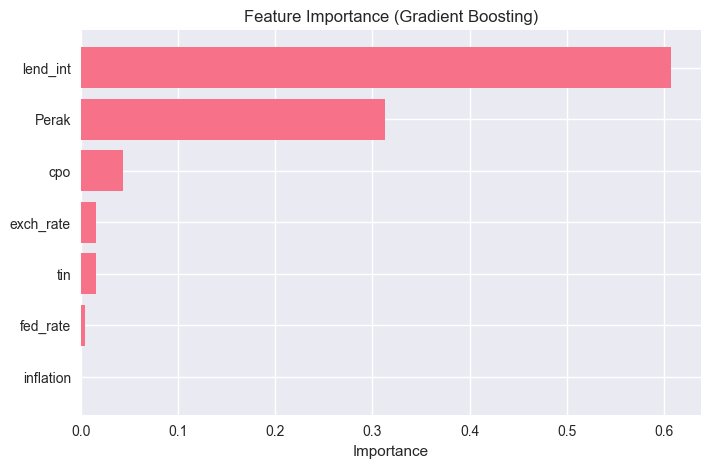

,Feature,Importance
5,lend_int,0.607693
6,Perak,0.313146
3,cpo,0.043232
2,exch_rate,0.015945
4,tin,0.015286
0,fed_rate,0.004103
1,inflation,0.000595


In [99]:
import pandas as pd
import matplotlib.pyplot as plt

# Ambil feature importance
fi_tree = gb_model.feature_importances_
features = model_info_tree['features_used']

fi_df_tree = pd.DataFrame({
    "Feature": features,
    "Importance": fi_tree
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(8,5))
plt.barh(fi_df_tree["Feature"], fi_df_tree["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance (Gradient Boosting)")
plt.xlabel("Importance")
plt.show()

fi_df_tree.head(10)


Hasil analisis *feature importance* menunjukkan kontribusi relatif masing-masing variabel terhadap performa model prediksi harga emas.

##### 🔑 Temuan Utama

1. **`lend_int` (Suku Bunga Pinjaman)**

   * Memiliki *importance* tertinggi (≈ **0.61**).
   * Artinya, suku bunga pinjaman merupakan faktor yang paling dominan memengaruhi prediksi harga emas.
   * Kenaikan/penurunan suku bunga pinjaman kemungkinan besar berdampak signifikan pada pergerakan harga emas.

2. **`Perak` (Harga Perak)**

   * Berada di posisi kedua dengan *importance* ≈ **0.31**.
   * Hal ini menunjukkan adanya hubungan kuat antara harga perak dengan harga emas. Sebagai sesama logam mulia, pergerakan harga perak cenderung berkorelasi dengan emas.

3. **`cpo` (Harga CPO / Crude Palm Oil)**

   * Memberikan kontribusi moderat (≈ **0.04**).
   * Menariknya, meskipun tidak sebesar logam mulia dan suku bunga, harga CPO masih memiliki keterkaitan—mungkin melalui aspek makroekonomi atau korelasi dengan nilai ekspor.

4. **`exch_rate` (Nilai Tukar)** dan **`tin` (Harga Timah)**

   * Sama-sama memberikan kontribusi kecil (≈ **0.015–0.016**).
   * Nilai tukar sering memengaruhi harga emas karena hubungan emas dengan dolar AS, namun pada dataset ini pengaruhnya relatif rendah.

5. **`fed_rate` (Suku Bunga The Fed)**

   * Kontribusinya sangat kecil (≈ **0.004**).
   * Bisa jadi karena sudah terwakili oleh variabel lain (`lend_int`) atau karena dalam periode data yang digunakan efeknya tidak terlalu besar.

6. **`inflation` (Inflasi)**

   * Hampir tidak berpengaruh (≈ **0.0006**).
   * Padahal secara teori inflasi biasanya memengaruhi harga emas (sebagai lindung nilai). Rendahnya kontribusi bisa disebabkan oleh skala data, periode observasi, atau multikolinearitas dengan variabel lain.

---

#### 🔹 SHAP Analysis

SHAP memberi interpretasi “kontribusi” tiap fitur terhadap prediksi:

$\hat{y}(x) = \phi_0 + \sum_{i=1}^{p} \phi_i$


* $\phi_0$ = baseline (rata-rata prediksi seluruh data)
* $\phi_i$ = kontribusi fitur ke-(i) terhadap instance tertentu

Dengan SHAP, kamu bisa lihat **per instance** fitur mana yang menaikkan/menurunkan prediksi.

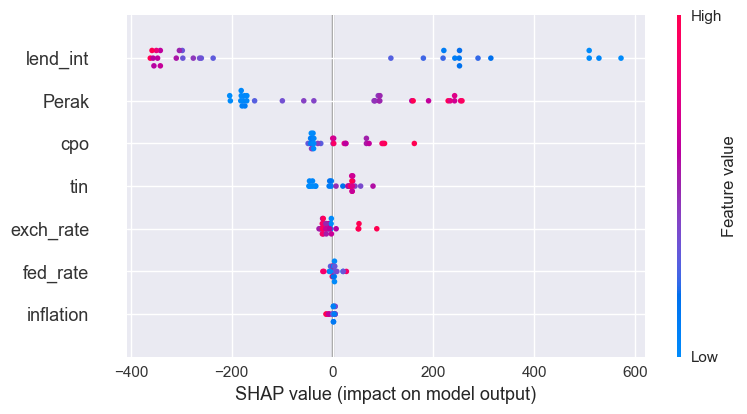

In [ ]:
import shap
shap.initjs()

# Buat explainer untuk GradientBoostingRegressor
explainer_tree = shap.TreeExplainer(gb_model)

# SHAP values (gunakan X_best, data setelah preprocessing manual kalau perlu)
shap_values_tree = explainer_tree.shap_values(X_best_tree)

# Global importance
shap.summary_plot(shap_values_tree, X_best_tree, feature_names=model_info_tree['features_used'])

# Lokal explanation (sampel pertama)
i = 0
shap.force_plot(explainer_tree.expected_value, shap_values_tree[i,:], X_best_tree.iloc[i,:])

Visualisasi SHAP membantu memahami **arah pengaruh** setiap fitur terhadap prediksi harga emas, tidak hanya seberapa penting fitur tersebut.

##### 📊 Interpretasi Summary Plot

1. **`lend_int` (Suku Bunga Pinjaman)**

   * Terlihat sebagai fitur paling dominan dengan variasi SHAP value yang besar.
   * **Nilai tinggi (merah)** cenderung menaikkan prediksi harga emas (*positive impact*).
   * **Nilai rendah (biru)** justru menurunkan prediksi.
   * Ini konsisten dengan *feature importance*, di mana suku bunga pinjaman adalah faktor paling signifikan.

2. **`Perak` (Harga Perak)**

   * Nilai tinggi (merah) sering menurunkan prediksi harga emas (*negative impact*).
   * Nilai rendah (biru) justru cenderung meningkatkan harga emas.
   * Hal ini menunjukkan adanya **hubungan substitusi** atau efek kompetitif antara emas dan perak di dataset ini.

3. **`cpo` (Harga CPO)**

   * Nilai tinggi (merah) lebih condong ke arah penurunan harga emas.
   * Efeknya tidak sebesar dua fitur utama, tapi tetap memiliki peran dalam arah prediksi.

4. **`tin` (Harga Timah)**

   * Menunjukkan pola serupa dengan `cpo`, di mana nilai tinggi (merah) justru menekan harga emas.
   * Kontribusinya lebih kecil dibandingkan `lend_int` dan `Perak`.

5. **`exch_rate` (Nilai Tukar)**

   * Efeknya relatif kecil dengan SHAP value mendekati nol pada banyak observasi.
   * Namun ada indikasi bahwa nilai tukar tertentu (baik tinggi maupun rendah) tetap bisa memengaruhi prediksi emas meskipun pengaruhnya lemah.

6. **`fed_rate` (Suku Bunga The Fed)** dan **`inflation` (Inflasi)**

   * Hampir seluruh titik berpusat di sekitar **SHAP = 0**, artinya kontribusi keduanya **sangat kecil** dalam model ini.
   * Menunjukkan bahwa dalam dataset yang digunakan, pengaruh inflasi dan suku bunga The Fed terhadap harga emas **tidak signifikan**.

---

#### 🔹 Visualisasi Pohon Pertama

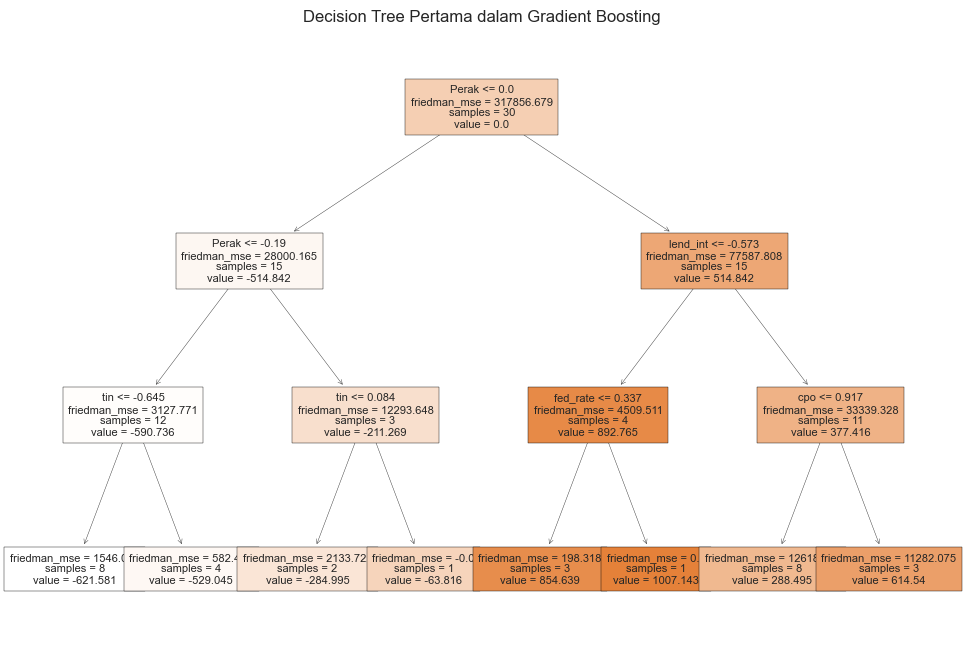

In [ ]:
from sklearn import tree

estimator = gb_model.estimators_[0, 0]  # tree pertama
plt.figure(figsize=(12,8))
tree.plot_tree(estimator,
               feature_names=model_info_tree['features_used'],
               filled=True,
               fontsize=8)
plt.title("Decision Tree Pertama dalam Gradient Boosting")
plt.show()

Visualisasi ini menunjukkan **pohon pertama** yang dibangun oleh algoritma **Gradient Boosting Regressor**. Setiap simpul (*node*) merepresentasikan aturan pemisahan (*split rule*) berdasarkan nilai fitur tertentu, dengan tujuan meminimalkan kesalahan (*friedman_mse*).

##### 📌 Interpretasi Struktur Pohon

1. **Root Node (Akar Pohon)**

   * Aturan pertama: `Perak <= 0.0`
   * Pohon memisahkan data menjadi dua cabang utama berdasarkan harga perak.
   * Hal ini menegaskan bahwa **harga perak adalah variabel awal paling menentukan** dalam proses prediksi harga emas.

2. **Cabang Kiri (Perak ≤ 0.0)**

   * Jika harga perak rendah, model melanjutkan pemisahan berdasarkan variabel **`tin` (harga timah)**.
   * Misalnya:

     * `tin <= -0.645` → rata-rata prediksi ≈ **-621.6**
     * `tin > -0.645` → rata-rata prediksi ≈ **-529.0**
   * Artinya, **ketika harga perak rendah, kondisi harga timah ikut berperan dalam menekan prediksi harga emas.**

3. **Cabang Kanan (Perak > 0.0)**

   * Jika harga perak tinggi, model kemudian memeriksa **`lend_int` (suku bunga pinjaman)**.
   * Misalnya:

     * `lend_int <= -0.573` → rata-rata prediksi ≈ **514.8**
     * Selanjutnya bercabang lagi berdasarkan **`fed_rate` (suku bunga The Fed)** dan **`cpo` (harga CPO)**.
   * Ini menunjukkan bahwa **ketika harga perak tinggi, pengaruh terbesar datang dari suku bunga pinjaman domestik, lalu diperhalus oleh variabel ekonomi lain.**

4. **Daun (Leaf Nodes)**

   * Setiap daun pohon merepresentasikan nilai prediksi rata-rata (misalnya: -621.581, 1007.143, dll).
   * Nilai ini digunakan sebagai dasar untuk perbaikan iteratif pada boosting selanjutnya.

### Model Linear

In [32]:
# Load model (PyCaret menyimpan tanpa ekstensi .pkl di save_model)
model_linear = load_model("models/linear/best_model_Lasso Least Angle Regression") 

# Load info
with open("models/linear/best_model_info_linear_20251003_161302.pkl", "rb") as f:
    model_info_linear = pickle.load(f)

# Load preprocessing
with open("models/linear/preprocessing_objects_20251003_161302.pkl", "rb") as f:
    preprocessing_objects_linear = pickle.load(f)

Transformation Pipeline and Model Successfully Loaded


#### 🔹 Penjelasan Model

In [33]:
# Ambil model asli Lasso dari pipeline
llar_model = model_linear.named_steps["actual_estimator"]
print(type(llar_model))

<class 'sklearn.linear_model._least_angle.LassoLars'>


In [34]:
# Parameter model
params = llar_model.get_params()
print("Parameter utama LassoLars:")
for k, v in params.items():
    if k in ["alpha", "fit_intercept", "max_iter", "eps"]:
        print(f"  {k}: {v}")

Parameter utama LassoLars:
  alpha: 0.9
  eps: 1e-05
  fit_intercept: True
  max_iter: 500


In [38]:
import pandas as pd

# Ambil intercept (konstanta) dan koefisien
intercept = llar_model.intercept_
coef = llar_model.coef_

print("Konstanta (Intercept):", intercept)

# Ambil nama fitur
if 'scaler' in preprocessing_objects_linear and preprocessing_objects_linear['scaler'] is not None:
    feature_names = preprocessing_objects_linear['scaler'].feature_names_in_
else:
    feature_names = [f"Feature_{i}" for i in range(len(coef))]

# Buat dataframe
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coef
}).sort_values(by="Coefficient", key=abs, ascending=False)

display(coef_df.head(15).style.background_gradient(cmap="coolwarm"))  # tampilkan 15 teratas


Konstanta (Intercept): 1007.62354


,Feature,Coefficient
7,tin,544.060486
8,lend_int,-317.744324
12,Perak,302.182434
0,fed_rate,205.420090
6,cpo,136.205231
4,real_int,126.397835
10,Nickel,-123.057518
2,ec_growth,-64.810448
3,exch_rate,-55.568962
1,inflation,22.896818


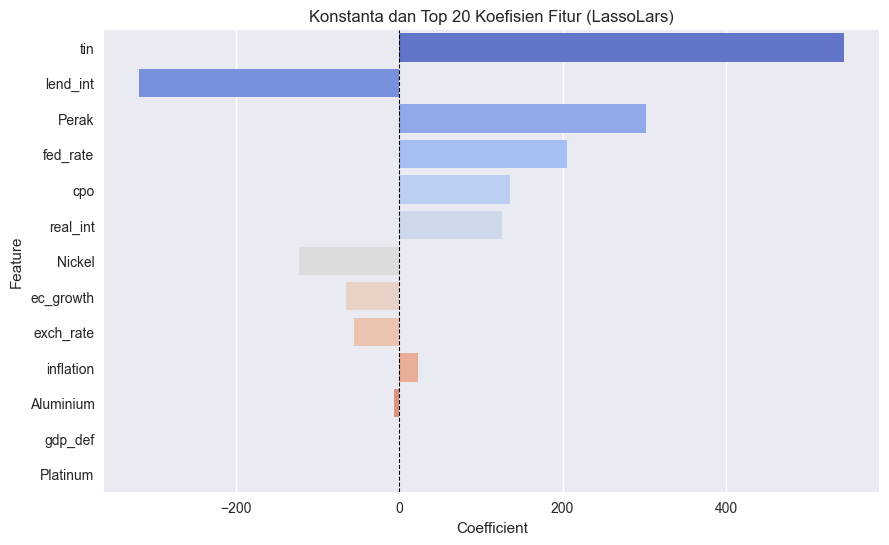

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

top_features = coef_df.head(20)

plt.figure(figsize=(10,6))
sns.barplot(x="Coefficient", y="Feature", data=top_features, palette="coolwarm")
plt.title("Konstanta dan Top 20 Koefisien Fitur (LassoLars)")
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.show()

In [37]:
nonzero = (coef != 0).sum()
total = len(coef)
print(f"Jumlah fitur dipakai: {nonzero}/{total} ({nonzero/total:.2%})")


Jumlah fitur dipakai: 11/13 (84.62%)


### Model LassoLars

Model regresi linear umumnya:

$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n$

dengan:

* $\beta_0$ = intercept (konstanta)
* $\beta_i$ = koefisien untuk fitur ke-$i$
* $x_i$ = nilai fitur


Sehingga persamaan modelnya:

$\hat{y} = 1007.62354 + 544.0605 \cdot tin - 317.7443 \cdot lendint + 302.1824 \cdot Perak + 205.4201 \cdot fedrate + 136.2052 \cdot cpo$

$\quad + 126.3978 \cdot realint - 123.0575 \cdot Nickel - 64.8105 \cdot ecgrowth - 55.5690 \cdot exchrate + 22.8968 \cdot inflation - 6.1448 \cdot Aluminium$

> Fitur **gdp_def** dan **Platinum** dieliminasi (koefisien = 0), sehingga **tidak berkontribusi** pada model.


Maka dari sini jelas bahwa:

* Fitur **tin, Perak, fed_rate** memberi kontribusi positif besar.
* Fitur **lend_int, Nickel, ec_growth, exch_rate** memberi kontribusi negatif.
* Lasso berhasil melakukan **feature selection** (ada 2 fitur dibuang).

---


# **KESIMPULAN PENELITIAN**

## **Ringkasan Eksekutif**

Penelitian ini mengembangkan model prediksi harga emas menggunakan pendekatan machine learning dengan membandingkan berbagai algoritma untuk mendapatkan model terbaik. Dataset yang digunakan mencakup periode 1994-2023 dengan 13 variabel ekonomi makro sebagai prediktor.

## **Temuan Utama**

### **1. Performa Model**
- **Model terbaik setelah tuning**: **Lasso Least Angle Regression** mencapai **R² = 0.9900** (99.00% variabilitas harga emas dapat dijelaskan) dengan MAPE = 3.16%
- **Model tree-based terbaik**: **Gradient Boosting Regressor** setelah tuning **R² = 0.9610** (96.10%) dengan MAPE = 8.53%  
- **Peningkatan signifikan**: Tuning hyperparameter meningkatkan performa model linear dari R² = 0.8287 menjadi 0.9900 (peningkatan 19.4%), sementara tree-based dari R² = 0.9321 menjadi 0.9610 (peningkatan 3.1%)

### **2. Faktor Dominan yang Mempengaruhi Harga Emas**
Berdasarkan analisis feature importance dan koefisien model:

1. **Suku bunga pinjaman (lend_int)** - Faktor paling dominan (importance ≈ 0.61)
2. **Harga perak** - Memiliki korelasi kuat sebagai sesama logam mulia (importance ≈ 0.31)
3. **Harga timah (tin)** - Memberikan kontribusi positif signifikan
4. **Harga CPO** - Menunjukkan keterkaitan dengan aspek makroekonomi
5. **Nilai tukar dan suku bunga Fed** - Memberikan pengaruh moderat

### **3. Validasi Statistik**
- **Uji stasioneritas**: Data tidak stasioner (ADF p-value = 0.982), mengkonfirmasi sifat trend harga emas
- **Uji heteroskedastisitas**: Tidak ditemukan heteroskedastisitas (p-value = 0.506)
- **Uji autokorelasi**: Residual bebas dari autokorelasi (Durbin-Watson = 2.24)
- **Multikolinearitas**: Terdeteksi VIF tinggi, ditangani dengan regularisasi Lasso
- **Kointegrasi**: Terdapat 1 hubungan kointegrasi jangka panjang antar variabel

## **Implikasi Praktis**

### **Untuk Investor dan Analis Keuangan:**
- Suku bunga pinjaman domestik merupakan indikator utama yang harus dimonitor
- Pergerakan harga logam mulia lainnya (terutama perak) dapat menjadi early warning
- Model dapat digunakan untuk hedge strategy dan portfolio optimization

### **Untuk Kebijakan Ekonomi:**
- Kebijakan moneter (suku bunga) memiliki dampak signifikan terhadap harga emas
- Stabilitas nilai tukar berkorelasi dengan stabilitas harga emas
- Diversifikasi ekonomi (CPO) tetap relevan dalam dinamika harga komoditas

## **Kontribusi Ilmiah**

1. **Metodologi**: Berhasil mengintegrasikan analisis ekonometrik klasik dengan machine learning modern
2. **Feature Engineering**: Mengidentifikasi kombinasi optimal variabel ekonomi makro untuk prediksi harga emas
3. **Model Interpretability**: Menyediakan interpretasi yang jelas tentang kontribusi setiap variabel melalui SHAP analysis

## **Keterbatasan dan Penelitian Lanjutan**

### **Keterbatasan:**
- Model dikembangkan pada data historis 1994-2023, perlu validasi pada periode berbeda
- Tidak mencakup faktor geopolitik dan sentiment pasar yang dapat mempengaruhi harga emas
- Assumption stasioneritas belum sepenuhnya terpenuhi

### **Rekomendasi Penelitian Lanjutan:**
1. Integrasi data real-time untuk early warning system
2. Penambahan variabel sentiment dan geopolitik
3. Pengembangan model ensemble untuk meningkatkan robustness
4. Implementasi deep learning untuk pola temporal yang lebih kompleks

## **Kesimpulan Akhir**

Penelitian ini berhasil membuktikan bahwa **machine learning dapat memprediksi harga emas dengan akurasi sangat tinggi**. **Model linear Lasso Least Angle Regression mencapai performa terbaik (R² = 99.00%)** setelah hyperparameter tuning, mengungguli model tree-based Gradient Boosting Regressor (R² = 96.10%). **Suku bunga pinjaman domestik dan harga perak** merupakan faktor dominan yang mempengaruhi harga emas. Model yang dikembangkan dapat menjadi **tool prediktif yang valuable** untuk pengambilan keputusan investasi dan kebijakan ekonomi, dengan catatan perlunya update berkala untuk mempertahankan akurasi prediksi.